# Overview


This notebook is created for solving the [Kaggle House Price Modeling Challenge](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques). The dataset has various categorical (nominal, binary, and ordinal variables) and numerical variables to determine the selling price of a house. The training dataset is rather small (1460) and it has a lot of variables (81). The lack of data and the huge number of variables was a pretty big challenge in this competition.

This notebook is my first base model to solving the problem. I perform a bit of EDA (exploratory data analysis) and I cycle through several models such as Linear Regression all the way to Xgboost and I also use a bit of model stacking to optimize model performance. 



# Good Notebooks to follow

Score 0.1064 https://www.kaggle.com/code/masumrumi/a-detailed-regression-guide-with-house-pricing <br>
Score 0.1184 https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition <br>
Score: 0.1197 https://www.kaggle.com/code/pablocorralgutirrez/house-prices-regressor <br>
Score 0.122 https://www.kaggle.com/code/ahmedgouda8wo/top6-rmse-0-12200-house-price-prediction 

## Table of Contents

1. [Utility Functions](#utility)
2. [Handling Missing Values](#missing_values)
3. [Understanding Target Variable](#target)
4. [Modeling](#modeling)

In [1]:
import sys
 
sys.path.append('C:\\Users\\Nikhil\\Data_Science_Projects')
from common_ds_modules import missing_values, data_manipulation, modeling
import os
import pandas as pd
import numpy as np
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import pickle
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor

C:\Users\Nikhil\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Utility Functions <a id='utility'></a>

In [2]:
def get_column(df, query=''):
    for c in df.columns:
        if query.lower() in c.lower():
            print(f'Column: {c}')

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


train_df['MSZoning'] = train_df['MSZoning'].apply(str)
train_df['MSZoning'] = train_df['MSZoning'].replace({'C (all)': 'C'})

train_df['MSSubClass'] = train_df['MSSubClass'].apply(str)

test_df['MSZoning'] = test_df['MSZoning'].apply(str)
test_df['MSZoning'] = test_df['MSZoning'].replace({'C (all)': 'C'})

In [4]:
train_df['MSSubClass'] = train_df['MSSubClass'].apply(lambda x: str(x))
test_df['MSSubClass'] = test_df['MSSubClass'].apply(lambda x: str(x))
train_df['LogSalePrice'] = np.log1p(train_df['SalePrice'])


### Fill in Missing Values <a id='missing_values'></a>

Getting rid of all columns that have more than 30% missing values. I chose 30 as a rather arbitrary number, I thought it was just right, if it is more than 30, then you will corrupt the variable distribution with the fill in value. 

For categorical variables I fill in missing values by using the mode, and for numerical variables I use the mean.

In [5]:
train_drop = missing_values.get_high_missing_value_columns(train_df, 30)
test_drop = missing_values.get_high_missing_value_columns(test_df, 30)


train_low_missing_vals_df = train_df.drop(train_drop, axis='columns')
test_low_missing_vals_df = test_df.drop(test_drop, axis='columns')

This function gets the numerical and categorical variables, and fills in missing values as well.

In [6]:
numerical_variables, categorical_variables = data_manipulation.get_numerical_categorical_variables(train_low_missing_vals_df,\
                                                                                            test_low_missing_vals_df, 'Id')
                                                                                                   

Numerical Variable: LotFrontage
[ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
 105.  73.  77.  64.  94.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]


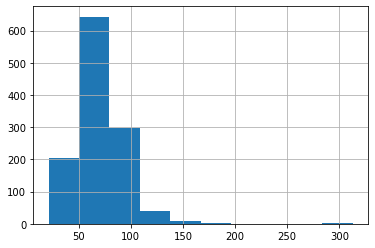

Numerical Variable: LotArea
[ 8450  9600 11250 ... 17217 13175  9717]


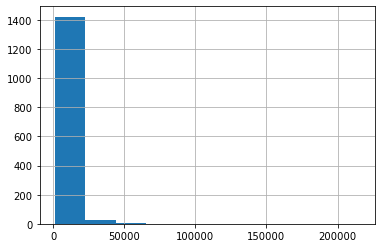

Numerical Variable: OverallQual
[ 7  6  8  5  9  4 10  3  1  2]


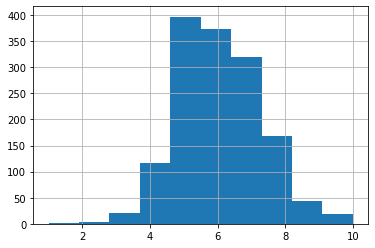

Numerical Variable: OverallCond
[5 8 6 7 4 2 3 9 1]


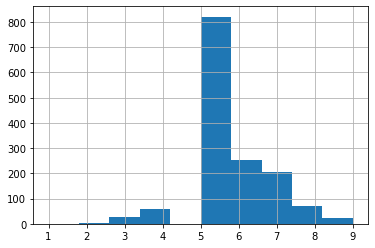

Numerical Variable: YearBuilt
[2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006
 1960 1929 1970 1967 1958 1930 2002 1968 2007 1951 1957 1927 1920 1966
 1959 1994 1954 1953 1955 1983 1975 1997 1934 1963 1981 1964 1999 1972
 1921 1945 1982 1998 1956 1948 1910 1995 1991 2009 1950 1961 1977 1985
 1979 1885 1919 1990 1969 1935 1988 1971 1952 1936 1923 1924 1984 1926
 1940 1941 1987 1986 2008 1908 1892 1916 1932 1918 1912 1947 1925 1900
 1980 1989 1992 1949 1880 1928 1978 1922 1996 2010 1946 1913 1937 1942
 1938 1974 1893 1914 1906 1890 1898 1904 1882 1875 1911 1917 1872 1905]


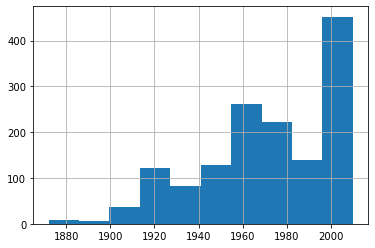

Numerical Variable: YearRemodAdd
[2003 1976 2002 1970 2000 1995 2005 1973 1950 1965 2006 1962 2007 1960
 2001 1967 2004 2008 1997 1959 1990 1955 1983 1980 1966 1963 1987 1964
 1972 1996 1998 1989 1953 1956 1968 1981 1992 2009 1982 1961 1993 1999
 1985 1979 1977 1969 1958 1991 1971 1952 1975 2010 1984 1986 1994 1988
 1954 1957 1951 1978 1974]


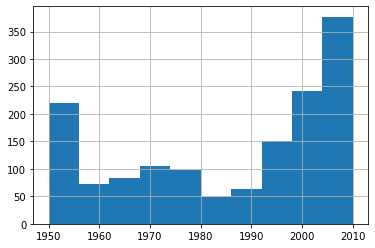

Numerical Variable: MasVnrArea
[1.960e+02 0.000e+00 1.620e+02 3.500e+02 1.860e+02 2.400e+02 2.860e+02
 3.060e+02 2.120e+02 1.800e+02 3.800e+02 2.810e+02 6.400e+02 2.000e+02
 2.460e+02 1.320e+02 6.500e+02 1.010e+02 4.120e+02 2.720e+02 4.560e+02
 1.031e+03 1.780e+02 5.730e+02 3.440e+02 2.870e+02 1.670e+02 1.115e+03
 4.000e+01 1.040e+02 5.760e+02 4.430e+02 4.680e+02 6.600e+01 2.200e+01
 2.840e+02 7.600e+01 2.030e+02 6.800e+01 1.830e+02 4.800e+01 2.800e+01
 3.360e+02 6.000e+02 7.680e+02 4.800e+02 2.200e+02 1.840e+02 1.129e+03
 1.160e+02 1.350e+02 2.660e+02 8.500e+01 3.090e+02 1.360e+02 2.880e+02
 7.000e+01 3.200e+02 5.000e+01 1.200e+02 4.360e+02 2.520e+02 8.400e+01
 6.640e+02 2.260e+02 3.000e+02 6.530e+02 1.120e+02 4.910e+02 2.680e+02
 7.480e+02 9.800e+01 2.750e+02 1.380e+02 2.050e+02 2.620e+02 1.280e+02
 2.600e+02 1.530e+02 6.400e+01 3.120e+02 1.600e+01 9.220e+02 1.420e+02
 2.900e+02 1.270e+02 5.060e+02 2.970e+02       nan 6.040e+02 2.540e+02
 3.600e+01 1.020e+02 4.720e+02 4.810e+02 1.080

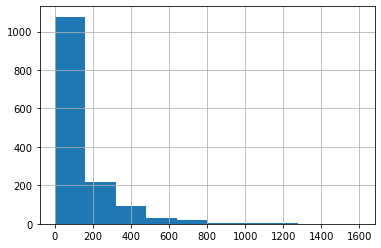

Numerical Variable: BsmtFinSF1
[ 706  978  486  216  655  732 1369  859    0  851  906  998  737  733
  578  646  504  840  188  234 1218 1277 1018 1153 1213  731  643  967
  747  280  179  456 1351   24  763  182  104 1810  384  490  649  632
  941  739  912 1013  603 1880  565  320  462  228  336  448 1201   33
  588  600  713 1046  648  310 1162  520  108  569 1200  224  705  444
  250  984   35  774  419  170 1470  938  570  300  120  116  512  567
  445  695  405 1005  668  821  432 1300  507  679 1332  209  680  716
 1400  416  429  222   57  660 1016  370  351  379 1288  360  639  495
  288 1398  477  831 1904  436  352  611 1086  297  626  560  390  566
 1126 1036 1088  641  617  662  312 1065  787  468   36  822  378  946
  341   16  550  524   56  321  842  689  625  358  402   94 1078  329
  929  697 1573  270  922  503 1334  361  672  506  714  403  751  226
  620  546  392  421  905  904  430  614  450  210  292  795 1285  819
  420  841  281  894 1464  700  262 1274  518 

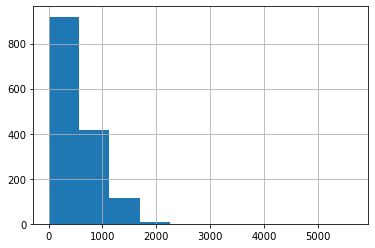

Numerical Variable: BsmtFinSF2
[   0   32  668  486   93  491  506  712  362   41  169  869  150  670
   28 1080  181  768  215  374  208  441  184  279  306  180  580  690
  692  228  125 1063  620  175  820 1474  264  479  147  232  380  544
  294  258  121  391  531  344  539  713  210  311 1120  165  532   96
  495  174 1127  139  202  645  123  551  219  606  612  480  182  132
  336  468  287   35  499  723  119   40  117  239   80  472   64 1057
  127  630  128  377  764  345 1085  435  823  500  290  324  634  411
  841 1061  466  396  354  149  193  273  465  400  682  557  230  106
  791  240  547  469  177  108  600  492  211  168 1031  438  375  144
   81  906  608  276  661   68  173  972  105  420  546  334  352  872
  110  627  163 1029]


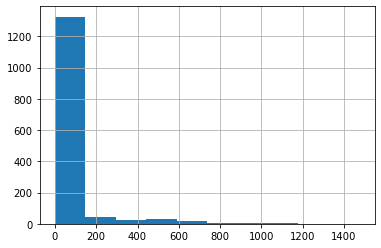

Numerical Variable: BsmtUnfSF
[ 150  284  434  540  490   64  317  216  952  140  134  177  175 1494
  520  832  426    0  468  525 1158  637 1777  200  204 1566  180  486
  207  649 1228 1234  380  408 1117 1097   84  326  445  383  167  465
 1296   83 1632  736  192  612  816   32  935  321  860 1410  148  217
  530 1346  576  318 1143 1035  440  747  701  343  280  404  840  724
  295 1768  448   36 1530 1065  384 1288  684 1013  402  635  163  168
  176  370  350  381  410  741 1226 1053  641  516  793 1139  550  905
  104  310  252 1125  203  728  732  510  899 1362   30  958  556  413
  479  297  658  262  891 1304  519 1907  336  107  432  403  811  396
  970  506  884  400  896  253  409   93 1200  572  774  769 1335  340
  882  779  112  470  294 1686  360  441  354  700  725  320  554  312
  968  504 1107  577  660   99  871  474  289  600  755  625 1121  276
  186 1424 1140  375   92  305 1176   78  274  311  710  686  457 1232
 1498 1010  160 2336  630  638  162   70 1357 1

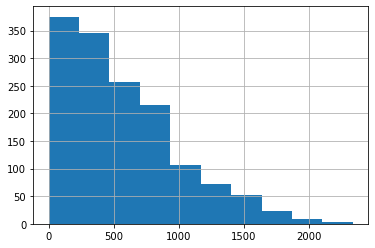

Numerical Variable: TotalBsmtSF
[ 856 1262  920  756 1145  796 1686 1107  952  991 1040 1175  912 1494
 1253  832 1004    0 1114 1029 1158  637 1777 1060 1566  900 1704 1484
  520  649 1228 1234 1398 1561 1117 1097 1297 1057 1088 1350  840  938
 1150 1752 1434 1656  736  955  794  816 1842  384 1425  970  860 1410
  780  530 1370  576 1143 1947 1453  747 1304 2223  845 1086  462  672
 1768  440  896 1237 1563 1065 1288  684  612 1013  990 1235  876 1214
  824  680 1588  960  458  950 1610  741 1226 1053  641  789  793 1844
  994 1264 1809 1028  729 1092 1125 1673  728  732 1080 1199 1362 1078
  660 1008  924  992 1063 1267 1461 1907  928  864 1734  910 1490 1728
  715  884  969 1710  825 1602 1200  572  774 1392 1232 1572 1541  882
 1149  644 1617 1582  720 1064 1606 1202 1151 1052 2216  968  504 1188
 1593  853  725 1431  855 1726 1360  755 1713 1121 1196  617  848 1424
 1140 1100 1157 1212  689 1070 1436  686  798 1248 1498 1010  713 2392
  630 1203  483 1373 1194 1462  894 1414  996

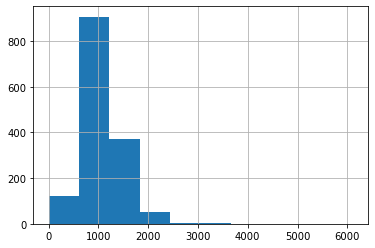

Numerical Variable: 1stFlrSF
[ 856 1262  920  961 1145  796 1694 1107 1022 1077 1040 1182  912 1494
 1253  854 1004 1296 1114 1339 1158 1108 1795 1060 1600  900 1704  520
  649 1228 1234 1700 1561 1132 1097 1297 1057 1152 1324 1328  884  938
 1150 1752 1518 1656  736  955  794  816 1842 1360 1425  983  860 1426
  780  581 1370  902 1143 2207 1479  747 1304 2223  845  885 1086  840
  526  952 1072 1768  682 1337 1563 1065  804 1301  684  612 1013  990
 1235  964 1260  905  680 1588  960  835 1225 1610  977 1535 1226 1053
 1047  789  997 1844 1216  774 1282 2259 1436  729 1092 1125 1699  728
  988  772 1080 1199 1586  958  660 1327 1721 1682 1214 1959  928  864
 1734  910 1501 1728  970  875  896  969 1710 1252 1200  572  991 1392
 1232 1572 1541  882 1149  808 1867 1707 1064 1362 1651 2158 1164 2234
  968  769  901 1340  936 1217 1224 1593 1549  725 1431  855 1726  929
 1713 1121 1279  865  848  720 1442 1696 1100 1180 1212  932  689 1236
  810 1137 1248 1498 1010  811 2392  630  483 15

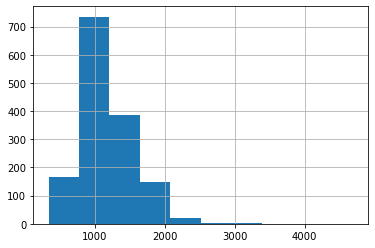

Numerical Variable: 2ndFlrSF
[ 854    0  866  756 1053  566  983  752 1142 1218  668 1320  631  716
  676  860 1519  530  808  977 1330  833  765  462  213  548  960  670
 1116  876  612 1031  881  790  755  592  939  520  639  656 1414  884
  729 1523  728  351  688  941 1032  848  836  475  739 1151  448  896
  524 1194  956 1070 1096  467  547  551  880  703  901  720  316 1518
  704 1178  754  601 1360  929  445  564  882  920  518  817 1257  741
  672 1306  504 1304 1100  730  689  591  888 1020  828  700  842 1286
  864  829 1092  709  844 1106  596  807  625  649  698  840  780  568
  795  648  975  702 1242 1818 1121  371  804  325  809 1200  871 1274
 1347 1332 1177 1080  695  167  915  576  605  862  495  403  838  517
 1427  784  711  468 1081  886  793  665  858  874  526  590  406 1157
  299  936  438 1098  766 1101 1028 1017 1254  378 1160  682  110  600
  678  834  384  512  930  868  224 1103  560  811  878  574  910  620
  687  546  902 1000  846 1067  914  660 1538 10

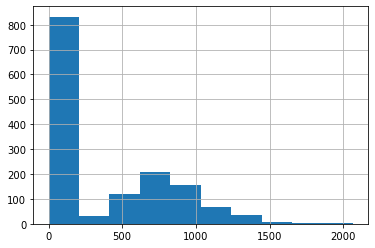

Numerical Variable: LowQualFinSF
[  0 360 513 234 528 572 144 392 371 390 420 473 156 515  80  53 232 481
 120 514 397 479 205 384]


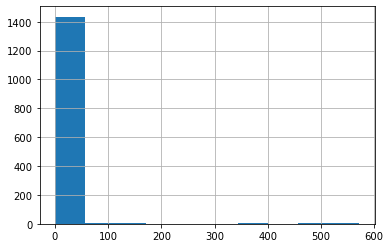

Numerical Variable: GrLivArea
[1710 1262 1786 1717 2198 1362 1694 2090 1774 1077 1040 2324  912 1494
 1253  854 1004 1296 1114 1339 2376 1108 1795 1060 1600  900 1704  520
 1317 1228 1234 1700 1561 2452 1097 1297 1057 1152 1324 1328  884  938
 1150 1752 2149 1656 1452  955 1470 1176  816 1842 1360 1425 1739 1720
 2945  780 1158 1111 1370 2034 2473 2207 1479  747 2287 2223  845 1718
 1086 1605  988  952 1285 1768 1230 2142 1337 1563 1065 1474 2417 1560
 1224 1526  990 1235  964 2291 1588  960  835 1225 1610 1732 1535 1226
 1818 1992 1047  789 1517 1844 1855 1430 2696 2259 2320 1458 1092 1125
 3222 1456 1123 1080 1199 1586  754  958  840 1348 1053 2157 2054 1327
 1721 1682 1214 1959 1852 1764  864 1734 1385 1501 1728 1709  875 2035
 1344  969 1993 1252 1200 1096 1968 1947 2462 1232 2668 1541  882 1616
 1355 1867 2161 1707 1382 1767 1651 2158 2060 1920 2234  968 1525 1802
 1340 2082 3608 1217 1593 2727 1431 1726 3112 2229 1713 1121 1279 1310
  848 1284 1442 1696 1100 2062 1212 1392 1236 1

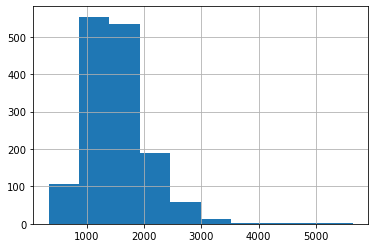

Numerical Variable: BsmtFullBath
[1 0 2 3]


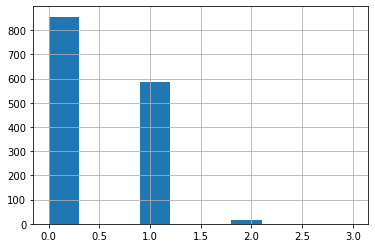

Numerical Variable: BsmtHalfBath
[0 1 2]


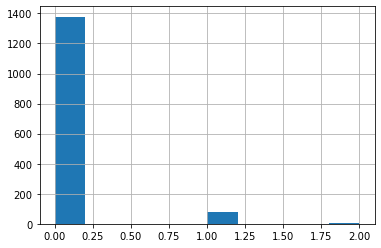

Numerical Variable: FullBath
[2 1 3 0]


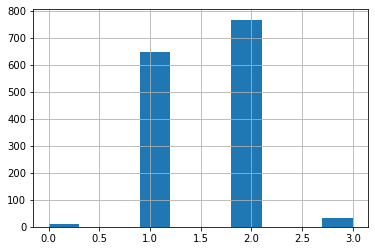

Numerical Variable: HalfBath
[1 0 2]


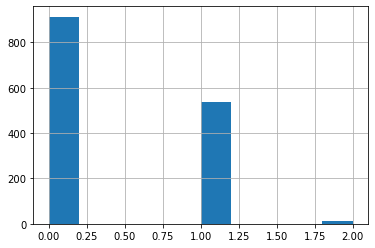

Numerical Variable: BedroomAbvGr
[3 4 1 2 0 5 6 8]


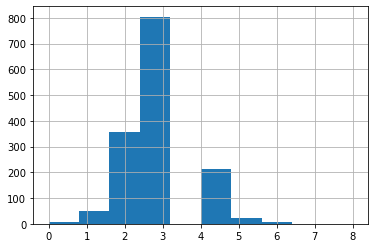

Numerical Variable: KitchenAbvGr
[1 2 3 0]


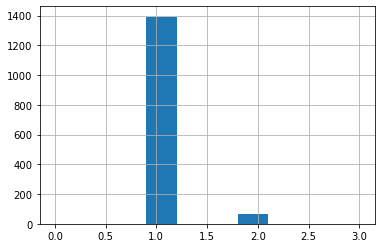

Numerical Variable: TotRmsAbvGrd
[ 8  6  7  9  5 11  4 10 12  3  2 14]


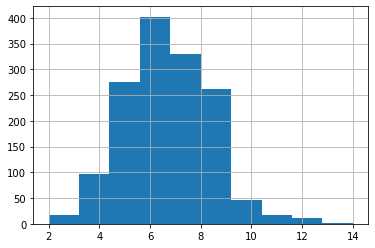

Numerical Variable: Fireplaces
[0 1 2 3]


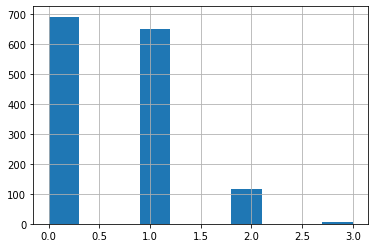

Numerical Variable: GarageYrBlt
[2003. 1976. 2001. 1998. 2000. 1993. 2004. 1973. 1931. 1939. 1965. 2005.
 1962. 2006. 1960. 1991. 1970. 1967. 1958. 1930. 2002. 1968. 2007. 2008.
 1957. 1920. 1966. 1959. 1995. 1954. 1953.   nan 1983. 1977. 1997. 1985.
 1963. 1981. 1964. 1999. 1935. 1990. 1945. 1987. 1989. 1915. 1956. 1948.
 1974. 2009. 1950. 1961. 1921. 1900. 1979. 1951. 1969. 1936. 1975. 1971.
 1923. 1984. 1926. 1955. 1986. 1988. 1916. 1932. 1972. 1918. 1980. 1924.
 1996. 1940. 1949. 1994. 1910. 1978. 1982. 1992. 1925. 1941. 2010. 1927.
 1947. 1937. 1942. 1938. 1952. 1928. 1922. 1934. 1906. 1914. 1946. 1908.
 1929. 1933.]


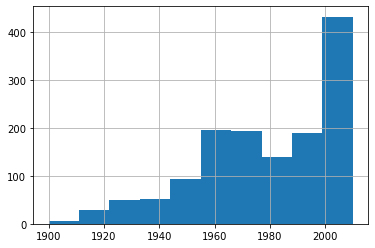

Numerical Variable: GarageCars
[2 3 1 0 4]


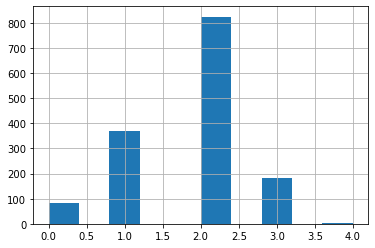

Numerical Variable: GarageArea
[ 548  460  608  642  836  480  636  484  468  205  384  736  352  840
  576  516  294  853  280  534  572  270  890  772  319  240  250  271
  447  556  691  672  498  246    0  440  308  504  300  670  826  386
  388  528  894  565  641  288  645  852  558  220  667  360  427  490
  379  297  283  509  405  758  461  400  462  420  432  506  684  472
  366  476  410  740  648  273  546  325  792  450  180  430  594  390
  540  264  530  435  453  750  487  624  471  318  766  660  470  720
  577  380  434  866  495  564  312  625  680  678  726  532  216  303
  789  511  616  521  451 1166  252  497  682  666  786  795  856  473
  398  500  349  454  644  299  210  431  438  675  968  721  336  810
  494  457  818  463  604  389  538  520  309  429  673  884  868  492
  413  924 1053  439  671  338  573  732  505  575  626  898  529  685
  281  539  418  588  282  375  683  843  552  870  888  746  708  513
 1025  656  872  292  441  189  880  676  301 

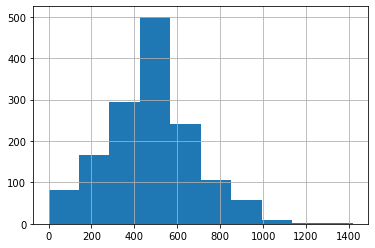

Numerical Variable: WoodDeckSF
[  0 298 192  40 255 235  90 147 140 160  48 240 171 100 406 222 288  49
 203 113 392 145 196 168 112 106 857 115 120  12 576 301 144 300  74 127
 232 158 352 182 180 166 224  80 367  53 188 105  24  98 276 200 409 239
 400 476 178 574 237 210 441 116 280 104  87 132 238 149 355  60 139 108
 351 209 216 248 143 365 370  58 197 263 123 138 333 250 292  95 262  81
 289 124 172 110 208 468 256 302 190 340 233 184 201 142 122 155 670 135
 495 536 306  64 364 353  66 159 146 296 125  44 215 264  88  89  96 414
 519 206 141 260 324 156 220  38 261 126  85 466 270  78 169 320 268  72
 349  42  35 326 382 161 179 103 253 148 335 176 390 328 312 185 269 195
  57 236 517 304 198 426  28 316 322 307 257 219 416 344 380  68 114 327
 165 187 181  92 228 245 503 315 241 303 133 403  36  52 265 207 150 290
 486 278  70 418 234  26 342  97 272 121 243 511 154 164 173 384 202  56
 321  86 194 421 305 117 550 509 153 394 371  63 252 136 186 170 474 214
 199 728 436  55 431

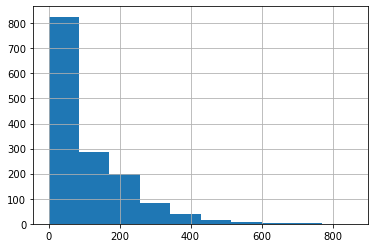

Numerical Variable: OpenPorchSF
[ 61   0  42  35  84  30  57 204   4  21  33 213 112 102 154 159 110  90
  56  32  50 258  54  65  38  47  64  52 138 104  82  43 146  75  72  70
  49  11  36 151  29  94 101 199  99 234 162  63  68  46  45 122 184 120
  20  24 130 205 108  80  66  48  25  96 111 106  40 114   8 136 132  62
 228  60 238 260  27  74  16 198  26  83  34  55  22  98 172 119 208 105
 140 168  28  39 148  12  51 150 117 250  10  81  44 144 175 195 128  76
  17  59 214 121  53 231 134 192 123  78 187  85 133 176 113 137 125 523
 100 285  88 406 155  73 182 502 274 158 142 243 235 312 124 267 265  87
 288  23 152 341 116 160 174 247 291  18 170 156 166 129 418 240  77 364
 188 207  67  69 131 191  41 118 252 189 282 135  95 224 169 319  58  93
 244 185 200  92 180 263 304 229 103 211 287 292 241 547  91  86 262 210
 141  15 126 236]


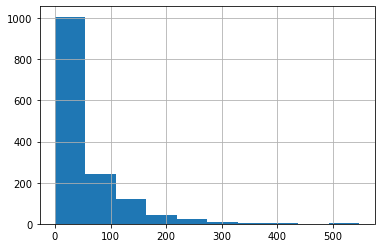

Numerical Variable: EnclosedPorch
[  0 272 228 205 176  87 172 102  37 144  64 114 202 128 156  44  77 192
 140 180 183  39 184  40 552  30 126  96  60 150 120 112 252  52 224 234
 244 268 137  24 108 294 177 218 242  91 160 130 169 105  34 248 236  32
  80 115 291 116 158 210  36 200  84 148 136 240  54 100 189 293 164 216
 239  67  90  56 129  98 143  70 386 154 185 134 196 264 275 230 254  68
 194 318  48  94 138 226 174  19 170 220 214 280 190 330 208 145 259  81
  42 123 162 286 168  20 301 198 221 212  50  99]


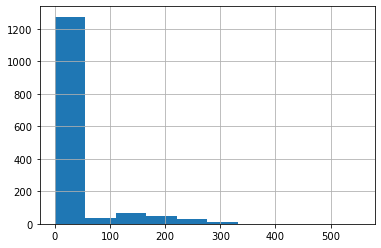

Numerical Variable: 3SsnPorch
[  0 320 407 130 180 168 140 508 238 245 196 144 182 162  23 216  96 153
 290 304]


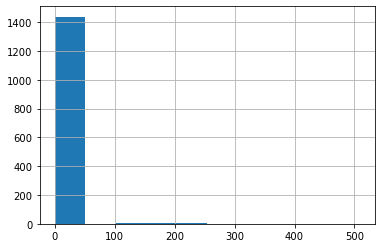

Numerical Variable: ScreenPorch
[  0 176 198 291 252  99 184 168 130 142 192 410 224 266 170 154 153 144
 128 259 160 271 234 374 185 182  90 396 140 276 180 161 145 200 122  95
 120  60 126 189 260 147 385 287 156 100 216 210 197 204 225 152 175 312
 222 265 322 190 233  63  53 143 273 288 263  80 163 116 480 178 440 155
 220 119 165  40]


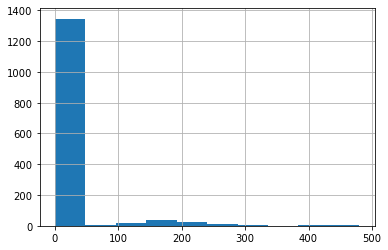

Numerical Variable: PoolArea
[  0 512 648 576 555 480 519 738]


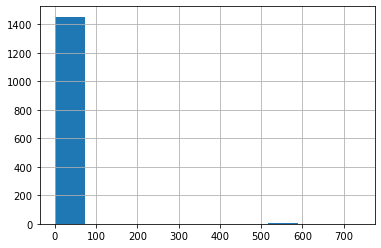

Numerical Variable: MiscVal
[    0   700   350   500   400   480   450 15500  1200   800  2000   600
  3500  1300    54   620   560  1400  8300  1150  2500]


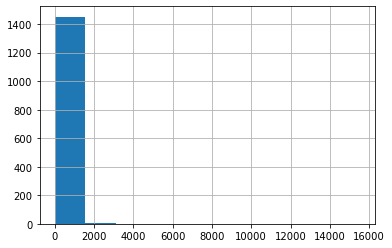

Numerical Variable: MoSold
[ 2  5  9 12 10  8 11  4  1  7  3  6]


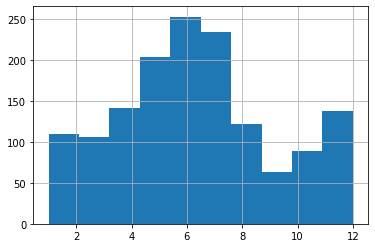

Numerical Variable: YrSold
[2008 2007 2006 2009 2010]


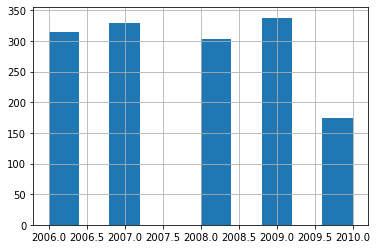

Numerical Variable: SalePrice
[208500 181500 223500 140000 250000 143000 307000 200000 129900 118000
 129500 345000 144000 279500 157000 132000 149000  90000 159000 139000
 325300 139400 230000 154000 256300 134800 306000 207500  68500  40000
 149350 179900 165500 277500 309000 145000 153000 109000  82000 160000
 170000 130250 141000 319900 239686 249700 113000 127000 177000 114500
 110000 385000 130000 180500 172500 196500 438780 124900 158000 101000
 202500 219500 317000 180000 226000  80000 225000 244000 185000 144900
 107400  91000 135750 136500 193500 153500 245000 126500 168500 260000
 174000 164500  85000 123600 109900  98600 163500 133900 204750 214000
  94750  83000 128950 205000 178000 118964 198900 169500 100000 115000
 190000 136900 383970 217000 259500 176000 155000 320000 163990 136000
 153900 181000  84500 128000  87000 150000 150750 220000 171000 231500
 166000 204000 125000 105000 222500 122000 372402 235000  79000 109500
 269500 254900 162500 412500 103200 152000 1275

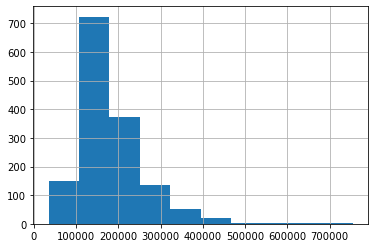

Numerical Variable: LogSalePrice
[12.24769912 12.10901644 12.31717117 11.84940484 12.4292202  11.8706069
 12.63460628 12.20607765 11.7745279  11.67844838 11.77144388 12.75130259
 11.87757552 12.54076115 11.96400745 11.79056478 11.9117083  11.40757606
 11.97666577 11.84223641 12.69250619 11.84510995 12.34583894 11.94471437
 12.45410781 11.8115549  12.63134365 12.24289144 11.13460362 10.59665973
 11.91405452 12.10016198 12.01673252 12.53357982 12.64109979 11.88449592
 11.93819974 11.59911234 11.31448672 11.98293534 12.0435596  11.77721864
 11.85652226 12.67576685 12.38708918 12.42801948 11.63515195 11.75195024
 12.08391066 11.64833884 11.60824474 12.86100121 11.77529742 12.1034916
 12.05815831 12.1884228  12.99175571 11.7352767  11.97035664 11.5228857
 12.2185001  12.29911207 12.66666021 12.10071769 12.3282947  11.28979441
 12.32386013 12.4049276  12.12811651 11.88380603 11.58432477 11.41862577
 11.8185776  11.82408722 12.17303796 11.94146236 12.40901757 11.74800549
 12.03469696 12.46844

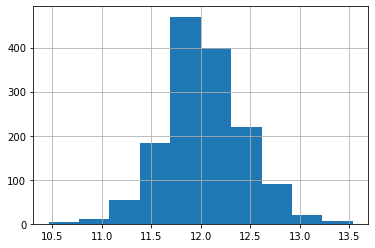

In [7]:
for n in numerical_variables:
    print(f'Numerical Variable: {n}')
    print(train_low_missing_vals_df[n].unique())
    train_low_missing_vals_df[n].hist()
    plt.show()
    #print(f'{n} \n\n distribution \n\n {train_df[n].unique()} \n\n')

Sanity check to make sure that training and testing dataset don't have any columns with missing values after fill in.

In [8]:
missing_values.get_null_columns(train_low_missing_vals_df)
missing_values.get_null_columns(test_low_missing_vals_df)

Column: LotFrontage has 259 missing values
Column: MasVnrType has 8 missing values
Column: MasVnrArea has 8 missing values
Column: BsmtQual has 37 missing values
Column: BsmtCond has 37 missing values
Column: BsmtExposure has 38 missing values
Column: BsmtFinType1 has 37 missing values
Column: BsmtFinType2 has 38 missing values
Column: Electrical has 1 missing values
Column: GarageType has 81 missing values
Column: GarageYrBlt has 81 missing values
Column: GarageFinish has 81 missing values
Column: GarageQual has 81 missing values
Column: GarageCond has 81 missing values
Column: LotFrontage has 227 missing values
Column: Utilities has 2 missing values
Column: Exterior1st has 1 missing values
Column: Exterior2nd has 1 missing values
Column: MasVnrType has 16 missing values
Column: MasVnrArea has 15 missing values
Column: BsmtQual has 44 missing values
Column: BsmtCond has 45 missing values
Column: BsmtExposure has 44 missing values
Column: BsmtFinType1 has 42 missing values
Column: Bsmt

In [9]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer

In [10]:
def plot_variable_dist(df, variables):
    for c in variables:
        plt.hist(train_df[c])
        plt.title(f'Distribution for {c}')
        plt.show()

## Understanding the target variable <a id='target'></a>

For this problem I am trying to predict the SalePrice, so that is the target. In this section I will create a few plots to examine the SalePrice variable

In [11]:
target = 'SalePrice'

C:\Users\Nikhil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


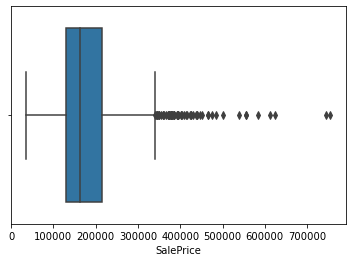

In [12]:
sns.boxplot(train_df[target])
plt.show()

In [13]:
q1 = np.percentile(train_df[target], 25)
q3 = np.percentile(train_df[target], 75)
iqr = q3 - q1
max_outlier = q3+1.5*iqr
print(f'Max outlier: {max_outlier}')
num_outliers = train_df[train_df['SalePrice'] > max_outlier].shape[0]
print(f'Percentage of outliers: {100*round(num_outliers/train_df.shape[0], 2)}')

Max outlier: 340037.5
Percentage of outliers: 4.0


#### Histogram of Sale Price

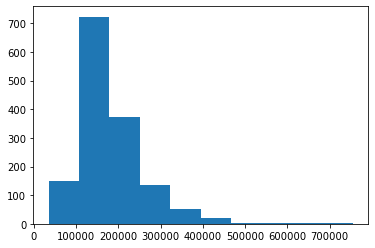

In [14]:
plt.hist(train_df['SalePrice'])
plt.show()

In [15]:
label = 'SalePrice'

### Correlation Matrix for all numerical variables

In [16]:
corr = train_df.corr()[label].sort_values()
valid_correlations = corr[(corr > 0.4) & (corr < 1)].index.tolist()
train_df[valid_correlations].corr()

,Fireplaces,MasVnrArea,GarageYrBlt,YearRemodAdd,YearBuilt,TotRmsAbvGrd,FullBath,1stFlrSF,TotalBsmtSF,GarageArea,GarageCars,GrLivArea,OverallQual,LogSalePrice
Fireplaces,1.000000,0.249070,0.046822,0.112581,0.147716,0.326114,0.243671,0.410531,0.339519,0.269141,0.300789,0.461679,0.396765,0.489450
MasVnrArea,0.249070,1.000000,0.252691,0.179618,0.315707,0.280682,0.276833,0.344501,0.363936,0.373066,0.364204,0.390857,0.411876,0.430809
GarageYrBlt,0.046822,0.252691,1.000000,0.642277,0.825667,0.148112,0.484557,0.233449,0.322445,0.564567,0.588920,0.231197,0.547766,0.541073
YearRemodAdd,0.112581,0.179618,0.642277,1.000000,0.592855,0.191740,0.439046,0.240379,0.291066,0.371600,0.420622,0.287389,0.550684,0.565608
YearBuilt,0.147716,0.315707,0.825667,0.592855,1.000000,0.095589,0.468271,0.281986,0.391452,0.478954,0.537850,0.199010,0.572323,0.586570
TotRmsAbvGrd,0.326114,0.280682,0.148112,0.191740,0.095589,1.000000,0.554784,0.409516,0.285573,0.337822,0.362289,0.825489,0.427452,0.534422
FullBath,0.243671,0.276833,0.484557,0.439046,0.468271,0.554784,1.000000,0.380637,0.323722,0.405656,0.469672,0.630012,0.550600,0.594771
1stFlrSF,0.410531,0.344501,0.233449,0.240379,0.281986,0.409516,0.380637,1.000000,0.819530,0.489782,0.439317,0.566024,0.476224,0.596981
TotalBsmtSF,0.339519,0.363936,0.322445,0.291066,0.391452,0.285573,0.323722,0.819530,1.000000,0.486665,0.434585,0.454868,0.537808,0.612134
GarageArea,0.269141,0.373066,0.564567,0.371600,0.478954,0.337822,0.405656,0.489782,0.486665,1.000000,0.882475,0.468997,0.562022,0.650888


In [17]:
# compartmentalize in another program

In [17]:
y_train = train_low_missing_vals_df['LogSalePrice']
train_model_data, test_model_data = data_manipulation.get_train_test_model_data(train_low_missing_vals_df, test_low_missing_vals_df,\
                                                                                numerical_variables, categorical_variables,\
                                                                                'SalePrice', target2='LogSalePrice')

train_drop_columns = list(set(train_model_data.columns) - set(test_model_data.columns))
train_model_data_final = train_model_data.drop(train_drop_columns, axis='columns')

In [19]:
train_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

## Modeling <a id='modeling'></a>

### Default random forest regressor

In [1]:
import pickle

In [2]:
%%time
rf_model_default = RandomForestRegressor().fit(train_model_data_final, y_train)
modeling.evaluate(train_model_data_final, y_train, rf_model_default)
filename = 'rf_default_model.pkl'
pickle.dump(rf_model_default, open(filename, 'wb'))


NameError: name 'RandomForestRegressor' is not defined

In [3]:
#modeling section in new program

### RandomForest Regressor

In [4]:
%%time
rf_param_grid = {
    'n_estimators': [30, 40],
    'max_depth':[2,3],
    'min_samples_split':[20, 30],
    'min_samples_leaf':[20, 30]
}

rf_model = modeling.get_random_forest_regressor_results(train_model_data_final, y_train, param_grid=rf_param_grid, test=None, y_test=None)

model = RandomForestRegressor(**rf_model.best_params_).fit(train_model_data_final, y_train)
modeling.evaluate(train_model_data_final, y_train,model)

NameError: name 'modeling' is not defined

### Decision Tree

In [5]:
%%time

dt_param_grid = {
    'max_depth':[2,3],
    'min_samples_split':[50, 30],
    'min_samples_leaf':[50, 30],
    'max_features' : [30, 40],
    'min_impurity_decrease': [i/100 for i in range(1, 3)],
    'ccp_alpha': [i/10 for i in range(1, 3)]
}

dt_model = modeling.get_decision_tree_model(train_model_data_final, y_train, dt_param_grid)
modeling.evaluate(train_model_data_final, y_train, dt_model)

NameError: name 'modeling' is not defined

###  XGBRegressor

In [6]:
%%time

xgb_param_grid = {
    'n_estimators': [30, 40],
    'max_depth':[2,3],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,3)],
    'reg_lambda': [i/100 for i in range(1,3)],
    'colsample_bytree': [i/10 for i in range(1, 3)],
    'min_child_weight': [10*i for i in range(1,3)],
    'learning_rate': [i/100 for i in range(1,3)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)

xgb_regressor = XGBRegressor(**xgb_model.best_params_)
scores = cross_val_score(xgb_regressor, train_model_data_final, y_train, scoring='neg_root_mean_squared_error', cv=5)
print(f'mean RMSLE = {-np.mean(scores)}, std RMSLE = {np.std(scores)}')

from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error

xgb_regressor = XGBRegressor(**xgb_model.best_params_).fit(train_model_data_final, y_train)
train_pred = xgb_regressor.predict(train_model_data_final)
train_pred = np.exp(train_pred) - 1
print(f'MAE = {mean_absolute_error(train_df["SalePrice"], train_pred)}')
print(f'RMSLE = {np.sqrt(mean_squared_error(train_df["SalePrice"], train_pred))}')
test_pred = xgb_regressor.predict(test_model_data.drop('MSSubClass_150', axis='columns'))
test_pred = np.exp(test_pred) - 1
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('xgb_predicted.csv', index=False)

NameError: name 'modeling' is not defined

### Linear Regression

In [7]:
lr_model = modeling.get_linear_regressor_model(train_model_data_final, y_train)
modeling.evaluate(train_model_data_final, y_train, lr_model)

NameError: name 'modeling' is not defined

### Ridge Regression

In [ ]:
%%time
ridge_param_grid = {
    'alpha':[i/100 for i in range(1, 6)] + [i/10 for i in range(1, 6)] + [i*10 for i in range(1, 6)] + [i*100 for i in range(1, 6)]
}
ridge_gs = modeling.get_ridge_regressor_model(train_model_data_final, y_train, ridge_param_grid)
ridge = Ridge(**ridge_gs.best_params_)
scaler = StandardScaler().fit(train_model_data_final, y_train)
train_scaled_data = scaler.transform(train_model_data_final)
modeling.evaluate(train_scaled_data, y_train, ridge)
ridge_gs.best_params_

In [ ]:
%%time
ridge_param_grid = {
    'alpha':[i*100 for i in range(4, 11)]
}
ridge_gs = modeling.get_ridge_regressor_model(train_model_data_final, y_train, ridge_param_grid)
ridge = Ridge(**ridge_gs.best_params_)
scaler = StandardScaler().fit(train_model_data_final, y_train)
train_scaled_data = scaler.transform(train_model_data_final)
modeling.evaluate(train_scaled_data, y_train, ridge)
ridge_gs.best_params_

### Lasso Regression

In [ ]:
%%time
lasso_param_grid = {
    'alpha':[i/100 for i in range(1, 3)]
}
lasso_gs = modeling.get_lasso_regression_model(train_model_data_final, y_train, lasso_param_grid)
lasso = Lasso(**lasso_gs.best_params_)
scaler = StandardScaler().fit(train_model_data_final, y_train)
scores = cross_val_score(lasso, scaler.transform(train_model_data_final), y_train, scoring='neg_root_mean_squared_error', cv=5)
print(f'mean RMSLE = {-np.mean(scores)}')

### Elastic Net Regression

In [ ]:
%%time
elastic_net_param_grid = {
    'alpha': [100*i for i in range(1,11)] + [i/100 for i in range(1,3)],
    'l1_ratio':[i/100 for i in range(1,3)]
}

elastic_net_model = modeling.get_elastic_net_regressor_model(train_model_data_final, y_train, elastic_net_param_grid)
best_elastic_net_model = ElasticNet(**elastic_net_model.best_params_)
modeling.evaluate(StandardScaler().fit_transform(train_model_data_final), y_train, best_elastic_net_model)

In [ ]:
elastic_net_model.best_params_

### KNN Regressor

In [ ]:
%%time

knn_param_grid = {
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['brute', 'ball_tree', 'kd_tree'],
    'n_neighbors' : [10*i for i in range(1,3)],
    'leaf_size': [10*i for i in range(1,3)],
    'p': [i for i in range(1,3)],
}


knn_grid_search = modeling.get_knn_regressor_model(train_model_data_final, y_train, knn_param_grid)
knn_regressor = KNeighborsRegressor(**knn_grid_search.best_params_)
modeling.evaluate(train_model_data_final, y_train, knn_regressor)

### Stacking Regressor with Lasso, Ridge, Elastic, Random Forest, and XGBRegressor as the final estimator

In [ ]:
estimators = [
     ('KNN', KNeighborsRegressor(**knn_grid_search.best_params_)),
    ('Lasso', Lasso(**lasso_gs.best_params_)),
    ('Ridge', Ridge(alpha=580)),
    ('Elastic', ElasticNet(**elastic_net_model.best_params_)),
    ('RandomForestRegressor', RandomForestRegressor())
]

final_estimator=XGBRegressor(**xgb_model.best_params_)

stacking_regressor = modeling.get_stacking_regressor(train_model_data_final, y_train, estimators, final_estimator)

modeling.evaluate(train_model_data_final, y_train, stacking_regressor)

In [ ]:
%%time
stacking_regressor = stacking_regressor.fit(train_model_data_final, y_train)
test_pred = stacking_regressor.predict(test_model_data.drop('MSSubClass_150', axis='columns'))
test_pred = np.exp(test_pred) - 1
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
pred = pred.rename(columns={'PredictedSalePrice', 'SalePrice'})
pred.to_csv('stacking_regressor_xgb_predicted.csv', index=False)

### Stacking Regressor with Lasso, Ridge, Elastic, XGBRegressor, and Random Forest as the final estimator

In [ ]:
%%time
estimators = [
     ('KNN', KNeighborsRegressor(**knn_grid_search.best_params_)),
    ('Lasso', Lasso(**lasso_gs.best_params_)),
    ('Ridge', Ridge(alpha=580)),
    ('Elastic', ElasticNet(**elastic_net_model.best_params_)),
    ('XGBRegressor', XGBRegressor(**xgb_model.best_params_))
]



final_estimator=RandomForestRegressor()

stacking_regressor = modeling.get_stacking_regressor(train_model_data_final, y_train, estimators, final_estimator)

modeling.evaluate(train_model_data_final, y_train, stacking_regressor)



In [ ]:
%%time
stacking_regressor = stacking_regressor.fit(train_model_data_final, y_train)
test_pred = stacking_regressor.predict(test_model_data.drop('MSSubClass_150', axis='columns'))
test_pred = np.exp(test_pred) - 1
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('stacking_regressor_rf.csv', index=False)

Both stacking regressors have far lower RMSLE's than the other models, it just goes to show you how powerful stacking is 

## Correcting Data for Skew

In [18]:
missing_value_pct_threshold = 30
train_drop = missing_values.get_high_missing_value_columns(train_df, missing_value_pct_threshold)
test_drop = missing_values.get_high_missing_value_columns(test_df, missing_value_pct_threshold)

train_low_missing_vals_df = train_df.drop(train_drop, axis='columns')
test_low_missing_vals_df = test_df.drop(test_drop, axis='columns')

In [65]:
x_df.dtypes

MSZoning    object
dtype: object

In [59]:
x_df.shape

(1460, 1)

In [82]:
train_df['MSZoning'].isna().sum()

0

In [86]:
train_df = pd.read_csv('train.csv')

x_df = train_df[['MSZoning']] # No need to reshape the array

ct = make_column_transformer(

(categorical_imputer, ['MSZoning']),

(OneHotEncoder(handle_unknown='ignore'), ['MSZoning']),

remainder='passthrough'

)

enc_x = ct.fit_transform(x_df)
enc_x

array([['RL', 0.0, 0.0, 0.0, 1.0, 0.0],
       ['RL', 0.0, 0.0, 0.0, 1.0, 0.0],
       ['RL', 0.0, 0.0, 0.0, 1.0, 0.0],
       ...,
       ['RL', 0.0, 0.0, 0.0, 1.0, 0.0],
       ['RL', 0.0, 0.0, 0.0, 1.0, 0.0],
       ['RL', 0.0, 0.0, 0.0, 1.0, 0.0]], dtype=object)

In [88]:
from sklearn.pipeline import make_pipeline

In [92]:
ct = make_column_transformer(
    (
        make_pipeline(categorical_imputer, OneHotEncoder(handle_unknown="ignore")),
        ["MSZoning"]
    ),
    remainder="passthrough", 
 )

enc_x = ct.fit_transform(x_df)
pd.DataFrame(enc_x)

,0
0,"(0, 3)\t1.0"
1,"(0, 3)\t1.0"
2,"(0, 3)\t1.0"
3,"(0, 3)\t1.0"
4,"(0, 3)\t1.0"
...,...
1455,"(0, 3)\t1.0"
1456,"(0, 3)\t1.0"
1457,"(0, 3)\t1.0"
1458,"(0, 3)\t1.0"


In [85]:
train_df = pd.read_csv('train.csv')
x_df = pd.DataFrame(np.array(train_df['MSZoning']).reshape(-1, 1))
cols_mapper = dict()
cols_mapper[0] = 'MSZoning'
x_df = x_df.rename(columns=cols_mapper)

ct = make_column_transformer(
    (categorical_imputer, ['MSZoning']),
    (OneHotEncoder(handle_unknown='ignore').set_output(transform='pandas'), ['MSZoning']),  
    remainder='passthrough')

enc_x = ct.fit_transform(x_df)
enc_x

AttributeError: 'OneHotEncoder' object has no attribute 'set_output'

In [83]:
train_df = pd.read_csv('train.csv')
x_df = pd.DataFrame(np.array(train_df['MSZoning']).reshape(-1, 1))
cols_mapper = dict()
cols_mapper[0] = 'MSZoning'
x_df = x_df.rename(columns=cols_mapper)

ct = make_column_transformer(
    (categorical_imputer, ['MSZoning']),
    (OneHotEncoder(handle_unknown='ignore'), ['MSZoning']),  
    remainder='passthrough')

enc_x = ct.fit_transform(x_df)
enc_x

array([['RL', 0.0, 0.0, 0.0, 1.0, 0.0],
       ['RL', 0.0, 0.0, 0.0, 1.0, 0.0],
       ['RL', 0.0, 0.0, 0.0, 1.0, 0.0],
       ...,
       ['RL', 0.0, 0.0, 0.0, 1.0, 0.0],
       ['RL', 0.0, 0.0, 0.0, 1.0, 0.0],
       ['RL', 0.0, 0.0, 0.0, 1.0, 0.0]], dtype=object)

In [72]:
x_df

,MSZoning
0,RL
1,RL
2,RL
3,RL
4,RL
...,...
1455,RL
1456,RL
1457,RL
1458,RL


In [71]:
pd.DataFrame(enc_x)

,0,1,2,3,4,5
0,RL,0.0,0.0,0.0,1.0,0.0
1,RL,0.0,0.0,0.0,1.0,0.0
2,RL,0.0,0.0,0.0,1.0,0.0
3,RL,0.0,0.0,0.0,1.0,0.0
4,RL,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...
1455,RL,0.0,0.0,0.0,1.0,0.0
1456,RL,0.0,0.0,0.0,1.0,0.0
1457,RL,0.0,0.0,0.0,1.0,0.0
1458,RL,0.0,0.0,0.0,1.0,0.0


In [73]:
ohe = OneHotEncoder()
x_df = ohe.fit_transform(x_df)
x_df

<1460x5 sparse matrix of type '<class 'numpy.float64'>'
	with 1460 stored elements in Compressed Sparse Row format>

In [75]:
pd.DataFrame(x_df)

,0
0,"(0, 3)\t1.0"
1,"(0, 3)\t1.0"
2,"(0, 3)\t1.0"
3,"(0, 3)\t1.0"
4,"(0, 3)\t1.0"
...,...
1455,"(0, 3)\t1.0"
1456,"(0, 3)\t1.0"
1457,"(0, 3)\t1.0"
1458,"(0, 3)\t1.0"


In [70]:
ohe.get_feature_names_out(['MSZoning'])

array(['MSZoning_C', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL',
       'MSZoning_RM'], dtype=object)

In [66]:
enc_x.get_feature_names_out(['MSZoning'])

AttributeError: 'numpy.ndarray' object has no attribute 'get_feature_names_out'

In [67]:
enc_x.categories_list

AttributeError: 'numpy.ndarray' object has no attribute 'categories_list'

In [19]:
numeric_feats = train_df.dtypes[train_df.dtypes != "object"].index
numeric_feats

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
       'MoSold', 'YrSold', 'SalePrice', 'LogSalePrice'],
      dtype='object')

In [20]:
from scipy.stats import skew

Variable: Id
Skew: 0.0


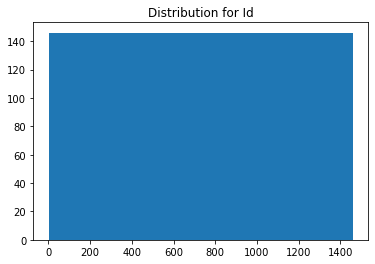

Variable: LotFrontage
Skew: 2.160865994705543


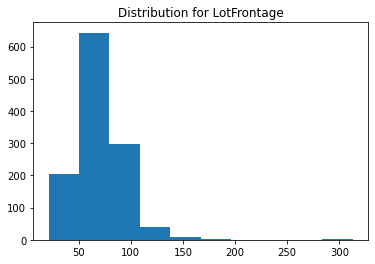

Variable: LotArea
Skew: 12.195142125084478


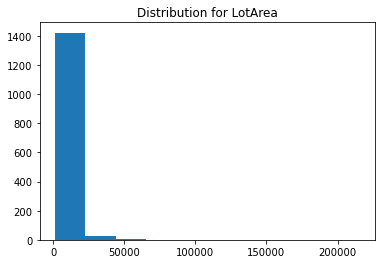

Variable: OverallQual
Skew: 0.2167209765258641


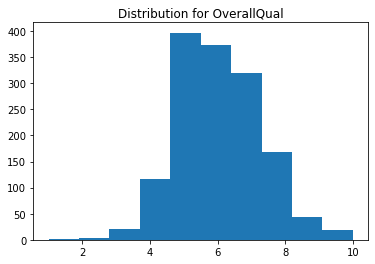

Variable: OverallCond
Skew: 0.6923552135520978


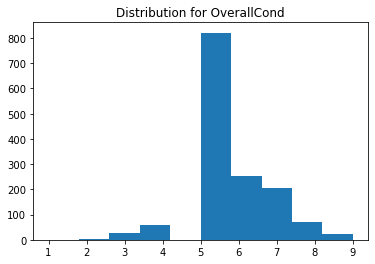

Variable: YearBuilt
Skew: -0.612830724202899


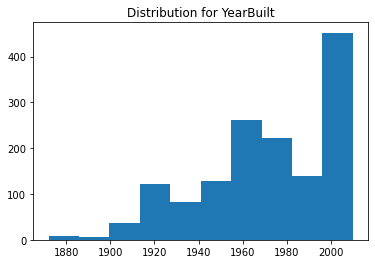

Variable: YearRemodAdd
Skew: -0.5030444967597948


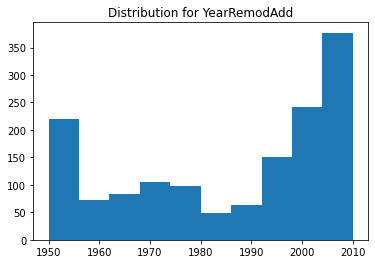

Variable: MasVnrArea
Skew: 2.6663261001607435


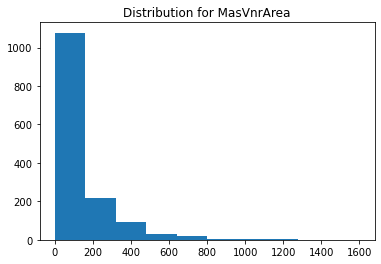

Variable: BsmtFinSF1
Skew: 1.6837708962341815


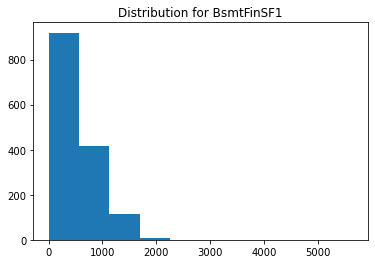

Variable: BsmtFinSF2
Skew: 4.250888017057445


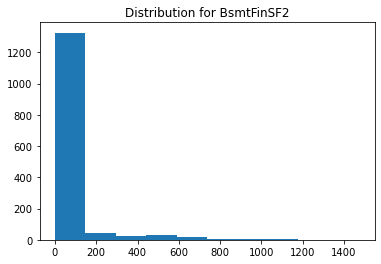

Variable: BsmtUnfSF
Skew: 0.9193227015582005


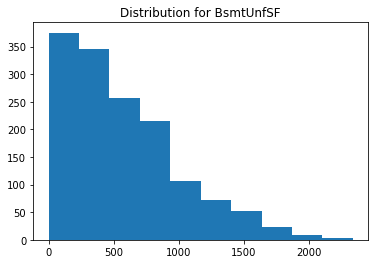

Variable: TotalBsmtSF
Skew: 1.522688086978629


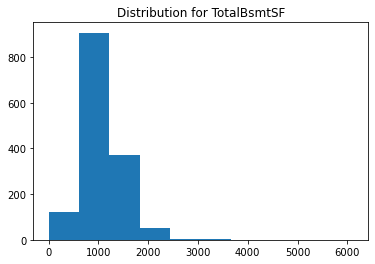

Variable: 1stFlrSF
Skew: 1.3753417421837937


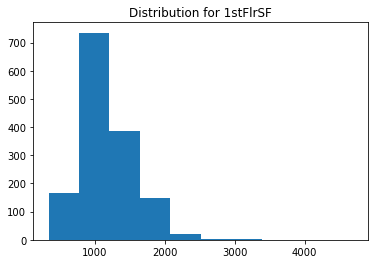

Variable: 2ndFlrSF
Skew: 0.8121942731961613


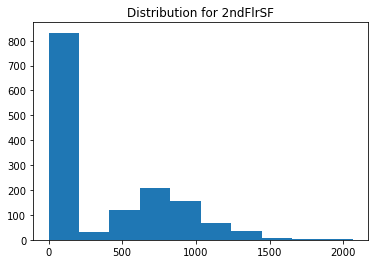

Variable: LowQualFinSF
Skew: 9.002080417658552


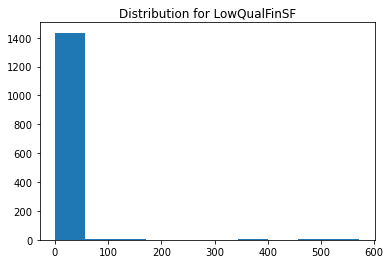

Variable: GrLivArea
Skew: 1.365155954773434


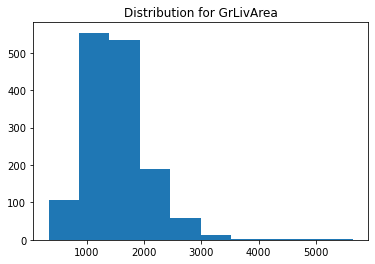

Variable: BsmtFullBath
Skew: 0.5954540376067279


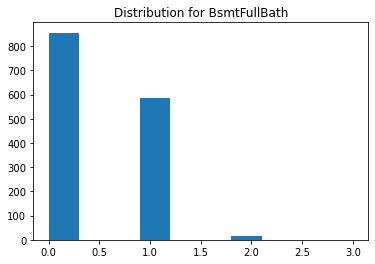

Variable: BsmtHalfBath
Skew: 4.0991856695420035


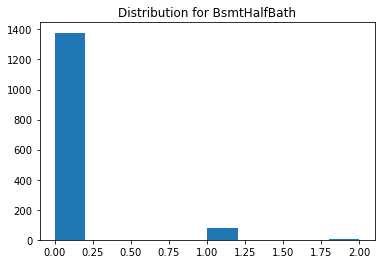

Variable: FullBath
Skew: 0.0365239844325461


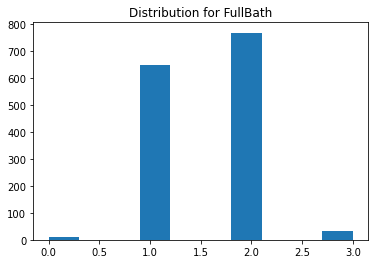

Variable: HalfBath
Skew: 0.6752028347742616


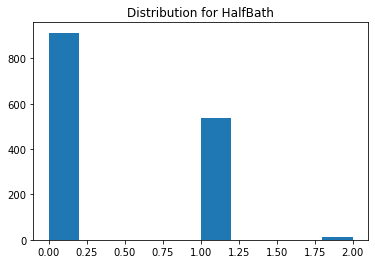

Variable: BedroomAbvGr
Skew: 0.21157244158228097


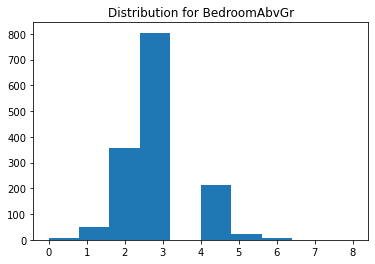

Variable: KitchenAbvGr
Skew: 4.483784093860484


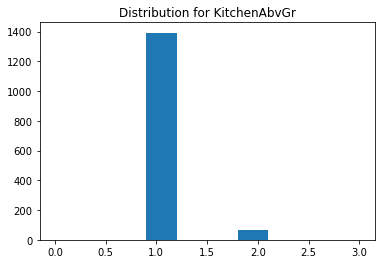

Variable: TotRmsAbvGrd
Skew: 0.6756457673102017


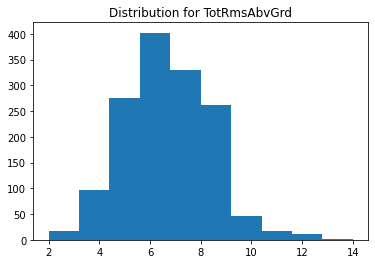

Variable: Fireplaces
Skew: 0.6488976310170327


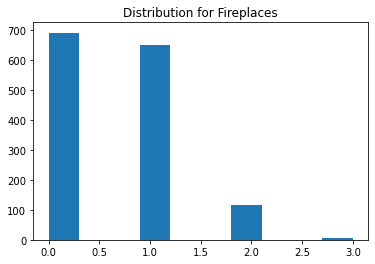

Variable: GarageYrBlt
Skew: -0.6487080129813099


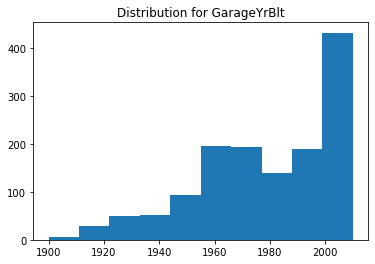

Variable: GarageCars
Skew: -0.34219689543081294


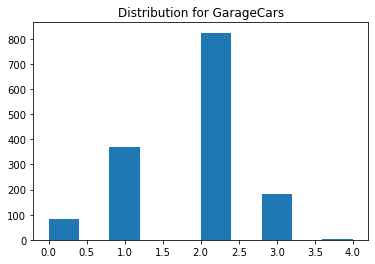

Variable: GarageArea
Skew: 0.1797959420587727


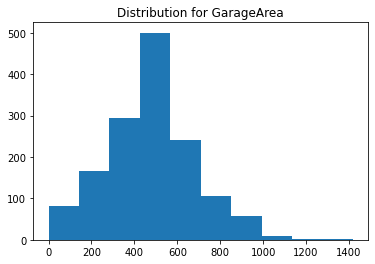

Variable: WoodDeckSF
Skew: 1.5397916998042025


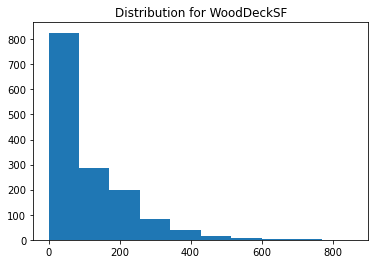

Variable: OpenPorchSF
Skew: 2.361911928568972


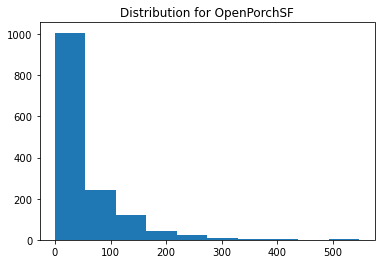

Variable: EnclosedPorch
Skew: 3.086696471376678


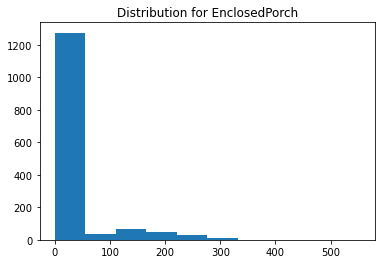

Variable: 3SsnPorch
Skew: 10.293752357165413


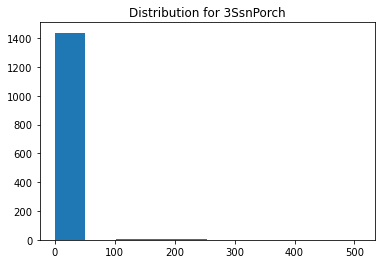

Variable: ScreenPorch
Skew: 4.1179773827954875


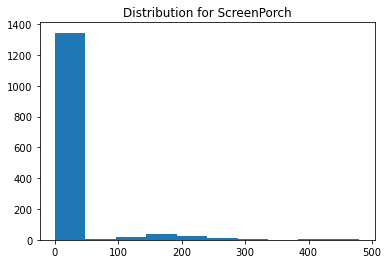

Variable: PoolArea
Skew: 14.813134660429398


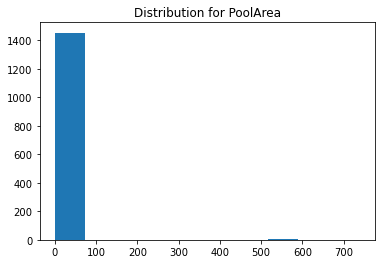

Variable: MiscVal
Skew: 24.4516396173223


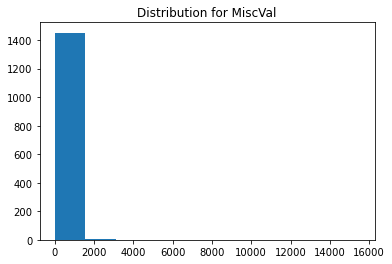

Variable: MoSold
Skew: 0.2118350601903434


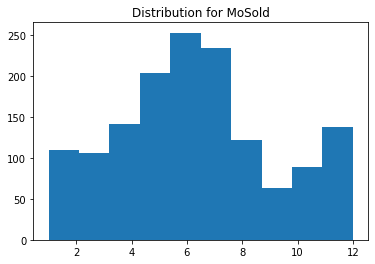

Variable: YrSold
Skew: 0.096169579618143


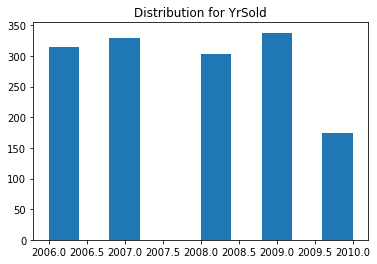

Variable: SalePrice
Skew: 1.880940746034036


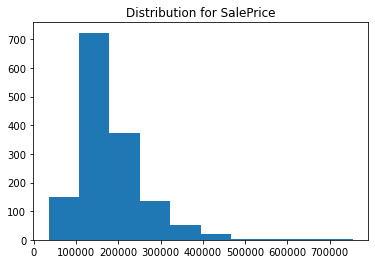

Variable: LogSalePrice
Skew: 0.12122191311528363


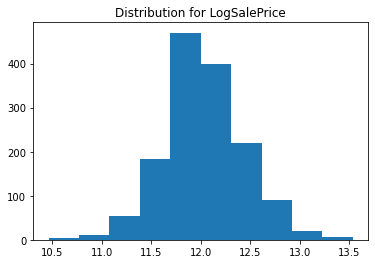

CPU times: total: 4 s
Wall time: 8.48 s


In [21]:
%%time
for n in numeric_feats:
    print(f'Variable: {n}')
    print(f'Skew: {skew(train_df[n].dropna())}')
    plt.hist(train_df[n])
    plt.title(f'Distribution for {n}')
    plt.show()

In [22]:
skewed_feats = train_low_missing_vals_df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75].index
skewed_feats = list(set(skewed_feats) - set(['SalePrice']))
len(set(['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal']).intersection(set(skewed_feats)))

20

In [23]:
def data_prep():
    train_df = pd.read_csv('train.csv')
    train_df['LogSalePrice'] = np.log1p(train_df['SalePrice'])
    test_df = pd.read_csv('test.csv')

    missing_value_pct_threshold = 30
    train_drop = missing_values.get_high_missing_value_columns(train_df, 30)
    test_drop = missing_values.get_high_missing_value_columns(test_df, 30)

    train_low_missing_vals_df = train_df.drop(train_drop, axis='columns')
    test_low_missing_vals_df = test_df.drop(test_drop, axis='columns')
    
    id_column = 'Id'
    numerical_variables, categorical_variables = data_manipulation.get_numerical_categorical_variables(train_low_missing_vals_df,\
                                                                                                test_low_missing_vals_df, 'Id')


    y_train = train_low_missing_vals_df['LogSalePrice']
    train_model_data, test_model_data = data_manipulation.get_train_test_model_data(train_low_missing_vals_df, test_low_missing_vals_df,\
                                                                                    numerical_variables, categorical_variables,\
                                                                                    'SalePrice', target2='LogSalePrice')

    train_drop_columns = list(set(train_model_data.columns) - set(test_model_data.columns))
    train_model_data_final = train_model_data.drop(train_drop_columns, axis='columns')
    
    return train_model_data_final, test_model_data

Data Preprocessing Step

In [23]:
ohe = OneHotEncoder(handle_unknown='ignore')
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')
ordinal_imputer = SimpleImputer(strategy='most_frequent')

In [24]:
categorical_variables, discrete_numerical_variables,\
continuous_numerical_variables = data_manipulation.get_variables(train_low_missing_vals_df, [], 'Id')
ind_continuous_variables = list(set(continuous_numerical_variables) - set(['SalePrice', 'LogSalePrice']))
numerical_variables = continuous_numerical_variables + discrete_numerical_variables

In [70]:
train_low_missing_vals_df[continuous_numerical_variables].isna().sum()

LotFrontage      259
LotArea            0
YearBuilt          0
YearRemodAdd       0
MasVnrArea         8
BsmtFinSF1         0
BsmtFinSF2         0
BsmtUnfSF          0
TotalBsmtSF        0
1stFlrSF           0
2ndFlrSF           0
LowQualFinSF       0
GrLivArea          0
GarageYrBlt       81
GarageArea         0
WoodDeckSF         0
OpenPorchSF        0
EnclosedPorch      0
3SsnPorch          0
ScreenPorch        0
MiscVal            0
SalePrice          0
LogSalePrice       0
dtype: int64

In [25]:
from sklearn.preprocessing import FunctionTransformer

In [26]:
log_transformer = FunctionTransformer(np.log1p)

In [27]:
ct = make_column_transformer(
    (numerical_imputer, ind_continuous_variables),
    (log_transformer, skewed_feats),
    (categorical_imputer, categorical_variables),
    (ohe, categorical_variables),  
    remainder='passthrough')

In [42]:
X_train = ct.fit_transform(train_low_missing_vals_df.drop(['SalePrice', 'LogSalePrice', 'Id'], axis='columns'))
X_test = ct.transform(train_low_missing_vals_df.drop(['Id'], axis='columns'))

In [41]:
test_low_missing_vals_df.columns


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPo

In [161]:
columns = list(train_low_missing_vals_df.columns)
var_indices = [columns.index(c) for c in columns]

In [140]:
X_train[:5].head()

,0,1,2,3,4,5,6,7,8,9,...,342,343,344,345,346,347,348,349,350,351
0,0.0,0.0,150.0,0.0,0.0,2003.0,1710.0,8450.0,196.0,856.0,...,5,1,2,1,3,8,0,2,2,2008
1,0.0,0.0,284.0,0.0,0.0,1976.0,1262.0,9600.0,0.0,1262.0,...,8,0,2,0,3,6,1,2,5,2007
2,0.0,0.0,434.0,0.0,0.0,2001.0,1786.0,11250.0,162.0,920.0,...,5,1,2,1,3,6,1,2,9,2008
3,0.0,0.0,540.0,272.0,0.0,1998.0,1717.0,9550.0,0.0,756.0,...,5,1,1,0,3,7,1,3,2,2006
4,0.0,0.0,490.0,0.0,0.0,2000.0,2198.0,14260.0,350.0,1145.0,...,5,1,2,1,4,9,1,3,12,2008


Now do entire modeling step all over again

In [ ]:
## Modeling Phase 2 <a id='modeling2'></a>

### Linear Regression

In [91]:
train.columns

RangeIndex(start=0, stop=352, step=1)

In [32]:
train_low_missing_vals_df.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish',
       'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive',
       'WoodDeckSF', 'OpenPo

In [40]:
X_train.shape

(1460, 351)

In [45]:
pd.DataFrame(X_train)[42]

0       RL
1       RL
2       RL
3       RL
4       RL
        ..
1455    RL
1456    RL
1457    RL
1458    RL
1459    RL
Name: 42, Length: 1460, dtype: object

In [95]:
X_train[42].value_counts()

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: 42, dtype: int64

In [117]:
'MSZoning' in categorical_variables

True

In [38]:
lr_model = modeling.get_linear_regressor_model(X_train, y_train)
modeling.evaluate(X_train, y_train, lr_model)

ValueError: could not convert string to float: 'RL'

### Decision Tree Regressor


In [ ]:

%%time

dt_param_grid = {
    'max_depth':[2,3],
    'min_samples_split':[50, 30],
    'min_samples_leaf':[50, 30],
    'max_features' : [30, 40],
    'min_impurity_decrease': [i/100 for i in range(1, 3)],
    'ccp_alpha': [i/10 for i in range(1, 3)]
}

dt_model = modeling.get_decision_tree_model(train_model_data_final, y_train, dt_param_grid)
modeling.evaluate(train_model_data_final, y_train, dt_model)

### XGB Regressor

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [30, 40],
    'max_depth':[2,3],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,3)],
    'reg_lambda': [i/100 for i in range(1,3)],
    'colsample_bytree': [i/10 for i in range(1, 3)],
    'min_child_weight': [10*i for i in range(1,3)],
    'learning_rate': [i/100 for i in range(1,3)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [30, 40],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [50, 40],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [50, 60],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [70, 60],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [70, 80],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [90, 80],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [90, 100],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [110, 100],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

In [28]:
num_permute = 1
for k, v in xgb_param_grid.items():
    num_permute = num_permute * len(v)
num_permute

2916

In [26]:
%%time

xgb_param_grid = {
    'n_estimators': [110, 120],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lamb

[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.03, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.02, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.02, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.02, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.3s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.3s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.3s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.7s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.02, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

{'reg_lambda': 0.02,
 'reg_alpha': 0.01,
 'n_estimators': 120,
 'max_leaves': 20,
 'max_depth': 6,
 'learning_rate': 0.03,
 'gamma': 0.03,
 'colsample_bytree': 0.3}

{'reg_lambda': 0.01,
 'reg_alpha': 0.01,
 'n_estimators': 120,
 'max_leaves': 30,
 'max_depth': 6,
 'learning_rate': 0.03,
 'gamma': 0.01,
 'colsample_bytree': 0.3} v2 best model

In [77]:
%%time

xgb_param_grid = {
    'n_estimators': [110, 120],
    'max_depth':[7,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.7s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.7s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.7s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.03, reg_lamb

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.7s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.6s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   1.0s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.7s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.7s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.8s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.7s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.7s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.3s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.02, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.02, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.3s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.3s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   1.0s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gam

{'reg_lambda': 0.01,
 'reg_alpha': 0.01,
 'n_estimators': 120,
 'max_leaves': 30,
 'max_depth': 6,
 'learning_rate': 0.03,
 'gamma': 0.01,
 'colsample_bytree': 0.3}

Fixed the range for max_depth, changed max_laves to 20,30,40, restricted reg_alpha & lambda to 0.01, 0.02 

colsample_bytree and learning_rate to 0.2-0.4 same 

{'reg_lambda': 0.01,
 'reg_alpha': 0.01,
 'n_estimators': 120,
 'max_leaves': 40,
 'max_depth': 5,
 'learning_rate': 0.04,
 'gamma': 0.01,
 'colsample_bytree': 0.2} gives RMSE of 0.1551
 
 v3 best model

In [78]:
%%time

xgb_param_grid = {
    'n_estimators': [110, 120],
    'max_depth':[5,6],
    'max_leaves':[40, 30, 20],
    'reg_alpha': [i/100 for i in range(1,3)],
    'reg_lambda': [i/100 for i in range(1,3)],
    'colsample_bytree': [i/10 for i in range(2, 5)],
    'learning_rate': [i/100 for i in range(2,5)],
    'gamma': [i/100 for i in range(1, 3)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lamb

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.7s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.7s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.7s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.7s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.7s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.8s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.7s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.7s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.7s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.7s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

{'reg_lambda': 0.01,
 'reg_alpha': 0.01,
 'n_estimators': 120,
 'max_leaves': 40,
 'max_depth': 5,
 'learning_rate': 0.04,
 'gamma': 0.01,
 'colsample_bytree': 0.2}

In [80]:
xgb_best_model_v3 = xgb_model.best_params_

Changed max leaves 3-5, LR: 0.03-0.05

In [84]:
%%time

xgb_param_grid = {
    'n_estimators': [110, 120],
    'max_depth':[5,6],
    'max_leaves':[40, 30, 50],
    'reg_alpha': [i/100 for i in range(1,3)],
    'reg_lambda': [i/100 for i in range(1,3)],
    'colsample_bytree': [i/10 for i in range(2, 5)],
    'learning_rate': [i/100 for i in range(3,6)],
    'gamma': [i/100 for i in range(1, 3)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_best_model_v4 = xgb_model.best_params_
xgb_best_model_v4

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.8s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.9s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lamb

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.8s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.05, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.05, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.3, gam

{'reg_lambda': 0.01,
 'reg_alpha': 0.02,
 'n_estimators': 120,
 'max_leaves': 30,
 'max_depth': 5,
 'learning_rate': 0.05,
 'gamma': 0.02,
 'colsample_bytree': 0.3}

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [130, 120],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [130, 140],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [150, 140],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

#### changing max depth range from 4-6, to 3-5

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [50, 60],
    'max_depth':[4,5,3],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

### Lassso Regression

In [44]:
scaled_train_data = StandardScaler().fit_transform(train_model_data_final)

In [45]:
%%time
lasso_param_grid = {
    'alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

lasso_gs = modeling.get_lasso_regression_model(scaled_train_data, y_train, lasso_param_grid)
lasso = Lasso(**lasso_gs.best_params_)
scaler = StandardScaler().fit(train_model_data_final, y_train)
modeling.evaluate(scaled_train_data, y_train, lasso)
lasso_gs.best_params_

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END .......................................

{'alpha': 0.01}

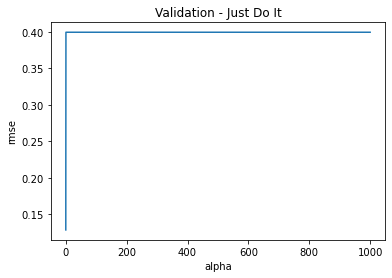

In [48]:
alphas = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
cv_lasso = [-cross_val_score(Lasso(alpha = alpha), scaled_train_data, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

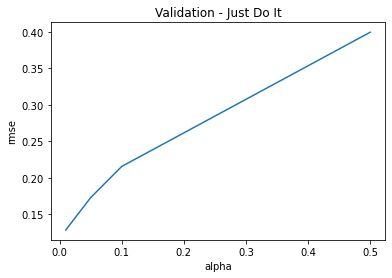

In [50]:
alphas = [0.01, 0.05, 0.1, 0.5]
cv_lasso = [-cross_val_score(Lasso(alpha = alpha), scaled_train_data, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

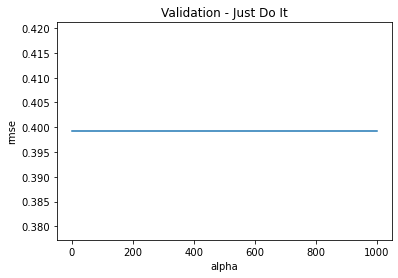

In [51]:
alphas = [1, 5, 10, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
cv_lasso = [-cross_val_score(Lasso(alpha = alpha), scaled_train_data, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

In [ ]:
%%time
lasso_param_grid = {
    'alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 75, 100]
}

lasso_gs = modeling.get_lasso_regression_model(train_model_data_final, y_train, lasso_param_grid)
lasso = Lasso(**lasso_gs.best_params_)
scaler = StandardScaler().fit(train_model_data_final, y_train)
train_scaled_data = scaler.transform(train_model_data_final)
modeling.evaluate(train_scaled_data, y_train, lasso)
lasso_gs.best_params_

In [ ]:
%%time
lasso = lasso.fit(train_scaled_data, y_train)
test_pred = lasso.predict(scaler.transform(test_model_data))
test_pred = np.expm1(test_pred)
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('lasso_predicted_skew_corrected.csv', index=False)

### Ridge Regression

In [72]:
%%time
ridge_param_grid = {
    'alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}
ridge_gs = modeling.get_ridge_regressor_model(train_model_data_final, y_train, ridge_param_grid)
ridge = Ridge(**ridge_gs.best_params_)
scaler = StandardScaler().fit(train_model_data_final, y_train)
train_scaled_data = scaler.transform(train_model_data_final)
modeling.evaluate(train_scaled_data, y_train, ridge)
ridge_gs.best_params_

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END .......................................

{'alpha': 400}

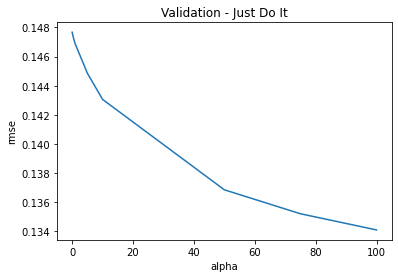

In [41]:
alphas = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 75, 100]
cv_ridge = [-cross_val_score(Ridge(alpha = alpha), scaled_train_data, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

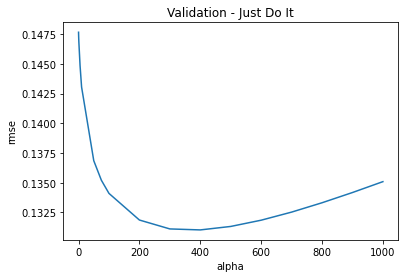

In [42]:
alphas = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
cv_ridge = [-cross_val_score(Ridge(alpha = alpha), scaled_train_data, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

In [43]:
(cv_ridge == cv_ridge.min())

0.01       False
0.05       False
0.10       False
0.50       False
1.00       False
5.00       False
10.00      False
50.00      False
75.00      False
100.00     False
200.00     False
300.00     False
400.00      True
500.00     False
600.00     False
700.00     False
800.00     False
900.00     False
1000.00    False
dtype: bool

In [52]:
cv_ridge

0.01       0.147667
0.05       0.147624
0.10       0.147572
0.50       0.147224
1.00       0.146874
5.00       0.144855
10.00      0.143058
50.00      0.136854
75.00      0.135209
100.00     0.134100
200.00     0.131859
300.00     0.131110
400.00     0.131027
500.00     0.131319
600.00     0.131845
700.00     0.132526
800.00     0.133313
900.00     0.134175
1000.00    0.135091
dtype: float64

In [ ]:
%%time
ridge_param_grid = {
    'alpha':[350, 375, 400, 425, 450]
}
ridge_gs = modeling.get_ridge_regressor_model(train_model_data_final, y_train, ridge_param_grid)
ridge = Ridge(**ridge_gs.best_params_)
scaler = StandardScaler().fit(train_model_data_final, y_train)
train_scaled_data = scaler.transform(train_model_data_final)
modeling.evaluate(train_scaled_data, y_train, ridge)
ridge_gs.best_params_

### Elastic Net Regressor


In [54]:
%%time
elastic_net_param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'l1_ratio':[0.01, 0.05, 0.1, 0.5, 1]
}

elastic_net_model = modeling.get_elastic_net_regressor_model(train_model_data_final, y_train, elastic_net_param_grid)
best_elastic_net_model = ElasticNet(**elastic_net_model.best_params_)
modeling.evaluate(StandardScaler().fit_transform(train_model_data_final), y_train, best_elastic_net_model)
elastic_net_model.best_params_

Fitting 5 folds for each of 95 candidates, totalling 475 fits
[CV] END ..........................alpha=0.01, l1_ratio=0.01; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.01; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.01; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.01; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.01; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.05; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.05; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.05; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.05; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.05; total time=   0.0s
[CV] END ...........................alpha=0.01, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.01,

[CV] END .............................alpha=1, l1_ratio=0.05; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.1; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.1; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.1; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.1; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.1; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.5; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.5; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.5; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.5; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.5; total time=   0.0s
[CV] END ................................alpha=1, l1_ratio=1; total time=   0.0s
[CV] END ...................

[CV] END ............................alpha=100, l1_ratio=0.5; total time=   0.0s
[CV] END ............................alpha=100, l1_ratio=0.5; total time=   0.0s
[CV] END ............................alpha=100, l1_ratio=0.5; total time=   0.0s
[CV] END ..............................alpha=100, l1_ratio=1; total time=   0.0s
[CV] END ..............................alpha=100, l1_ratio=1; total time=   0.0s
[CV] END ..............................alpha=100, l1_ratio=1; total time=   0.0s
[CV] END ..............................alpha=100, l1_ratio=1; total time=   0.0s
[CV] END ..............................alpha=100, l1_ratio=1; total time=   0.0s
[CV] END ...........................alpha=200, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=200, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=200, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=200, l1_ratio=0.01; total time=   0.0s
[CV] END ...................

[CV] END ..............................alpha=500, l1_ratio=1; total time=   0.0s
[CV] END ..............................alpha=500, l1_ratio=1; total time=   0.0s
[CV] END ..............................alpha=500, l1_ratio=1; total time=   0.0s
[CV] END ..............................alpha=500, l1_ratio=1; total time=   0.0s
[CV] END ..............................alpha=500, l1_ratio=1; total time=   0.0s
[CV] END ...........................alpha=600, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=600, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=600, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=600, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=600, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=600, l1_ratio=0.05; total time=   0.0s
[CV] END ...........................alpha=600, l1_ratio=0.05; total time=   0.0s
[CV] END ...................

mean RMSE = 0.12437102841406707, std RMSE = 0.016810853072299275
CPU times: total: 5.14 s
Wall time: 3.31 s


{'alpha': 0.05, 'l1_ratio': 0.1}

In [87]:
elastic_net_model.best_params_

{'alpha': 0.05, 'l1_ratio': 0.1}

### KNN Regressor

In [ ]:
%%time

knn_param_grid = {
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['brute', 'ball_tree', 'kd_tree'],
    'n_neighbors' : [10*i for i in range(1,3)],
    'leaf_size': [10*i for i in range(1,3)],
    'p': [i for i in range(1,3)],
}


knn_grid_search = modeling.get_knn_regressor_model(train_model_data_final, y_train, knn_param_grid)
knn_regressor = KNeighborsRegressor(**knn_grid_search.best_params_)
modeling.evaluate(train_model_data_final, y_train, knn_regressor)
knn_grid_search.best_params_

In [55]:
%%time

knn_param_grid = {
    'weights' : ['uniform'],
    'algorithm' : ['auto'],
    'n_neighbors' : [5,10,15, 20, 25, 30],
    'leaf_size': [20],
    'p': [1],
}


knn_grid_search = modeling.get_knn_regressor_model(train_model_data_final, y_train, knn_param_grid)
knn_regressor = KNeighborsRegressor(**knn_grid_search.best_params_)
modeling.evaluate(train_model_data_final, y_train, knn_regressor)
knn_grid_search.best_params_

C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=50. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=10, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=10, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=10, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=10, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=10, p=1, weights=uniform; tota

{'weights': 'uniform',
 'p': 1,
 'n_neighbors': 5,
 'leaf_size': 20,
 'algorithm': 'auto'}

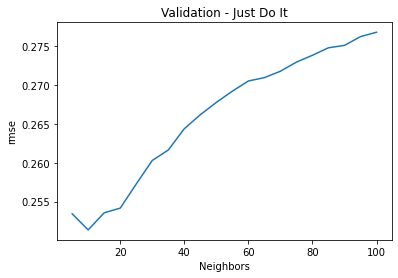

5      False
10      True
15     False
20     False
25     False
30     False
35     False
40     False
45     False
50     False
55     False
60     False
65     False
70     False
75     False
80     False
85     False
90     False
95     False
100    False
dtype: bool

In [63]:
n_neighbors = [i for i in range(5, 105, 5)]
cv_knn = [-cross_val_score(KNeighborsRegressor(n_neighbors = n), train_model_data_final, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for n in n_neighbors]
cv_knn = pd.Series(cv_knn, index = n_neighbors)
cv_knn.plot(title = "Validation - Just Do It")
plt.xlabel("Neighbors")
plt.ylabel("rmse")
plt.show()
cv_knn.min()
cv_knn == cv_knn.min() # 10 neighbors

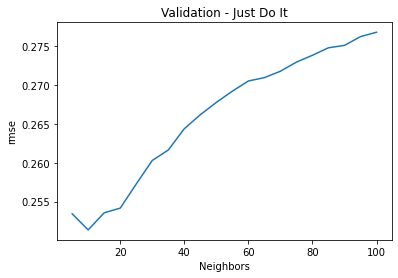

0.2513646469298177


5      False
10      True
15     False
20     False
25     False
30     False
35     False
40     False
45     False
50     False
55     False
60     False
65     False
70     False
75     False
80     False
85     False
90     False
95     False
100    False
dtype: bool

In [65]:
n_neighbors = [i for i in range(5, 105, 5)]
cv_knn = [-cross_val_score(KNeighborsRegressor(n_neighbors = n, weights='uniform', leaf_size=20, algorithm='auto'), train_model_data_final, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for n in n_neighbors]
cv_knn = pd.Series(cv_knn, index = n_neighbors)
cv_knn.plot(title = "Validation - Just Do It")
plt.xlabel("Neighbors")
plt.ylabel("rmse")
plt.show()
print(cv_knn.min())
cv_knn == cv_knn.min() #  neighbors

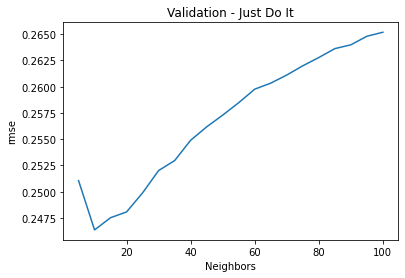

0.24636792411533887


5      False
10      True
15     False
20     False
25     False
30     False
35     False
40     False
45     False
50     False
55     False
60     False
65     False
70     False
75     False
80     False
85     False
90     False
95     False
100    False
dtype: bool

In [66]:
n_neighbors = [i for i in range(5, 105, 5)]
cv_knn = [-cross_val_score(KNeighborsRegressor(n_neighbors = n, weights='distance', algorithm='auto'), train_model_data_final, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for n in n_neighbors]
cv_knn = pd.Series(cv_knn, index = n_neighbors)
cv_knn.plot(title = "Validation - Just Do It")
plt.xlabel("Neighbors")
plt.ylabel("rmse")
plt.show()
print(cv_knn.min())
cv_knn == cv_knn.min() #  neighbors

### Changed leaf size to 20 and to euclidean distance

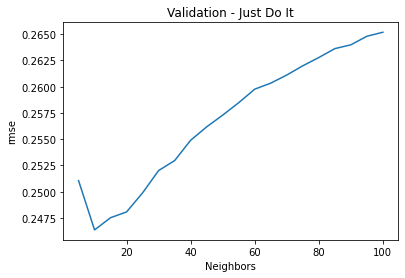

0.24636792411533887


5      False
10      True
15     False
20     False
25     False
30     False
35     False
40     False
45     False
50     False
55     False
60     False
65     False
70     False
75     False
80     False
85     False
90     False
95     False
100    False
dtype: bool

In [68]:
n_neighbors = [i for i in range(5, 105, 5)]
cv_knn = [-cross_val_score(KNeighborsRegressor(n_neighbors = n, leaf_size=20, p=2, weights='distance', algorithm='auto'), train_model_data_final, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for n in n_neighbors]
cv_knn = pd.Series(cv_knn, index = n_neighbors)
cv_knn.plot(title = "Validation - Just Do It")
plt.xlabel("Neighbors")
plt.ylabel("rmse")
plt.show()
print(cv_knn.min())
cv_knn == cv_knn.min() #  neighbors

### Changed leaf size to 40

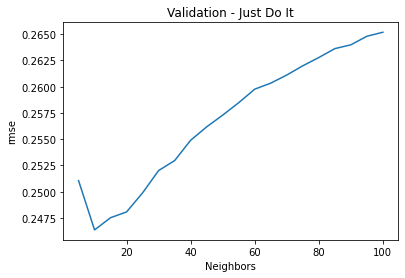

0.24636792411533887


5      False
10      True
15     False
20     False
25     False
30     False
35     False
40     False
45     False
50     False
55     False
60     False
65     False
70     False
75     False
80     False
85     False
90     False
95     False
100    False
dtype: bool

In [69]:
n_neighbors = [i for i in range(5, 105, 5)]
cv_knn = [-cross_val_score(KNeighborsRegressor(n_neighbors = n, leaf_size=40, p=2, weights='distance', algorithm='auto'), train_model_data_final, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for n in n_neighbors]
cv_knn = pd.Series(cv_knn, index = n_neighbors)
cv_knn.plot(title = "Validation - Just Do It")
plt.xlabel("Neighbors")
plt.ylabel("rmse")
plt.show()
print(cv_knn.min())
cv_knn == cv_knn.min() #  neighbors

In [ ]:
n_neighbors = [i for i in range(5, 105, 5)]
cv_knn = [-cross_val_score(KNeighborsRegressor(n_neighbors = n, leaf_size=40, weights='distance', algorithm='auto'), train_model_data_final, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for n in n_neighbors]
cv_knn = pd.Series(cv_knn, index = n_neighbors)
cv_knn.plot(title = "Validation - Just Do It")
plt.xlabel("Neighbors")
plt.ylabel("rmse")
plt.show()
print(cv_knn.min())
cv_knn == cv_knn.min() #  neighbors

In [ ]:
%%time

knn_param_grid = {
    'weights' : ['uniform'],
    'algorithm' : ['auto'],
    'n_neighbors' : [5*i for i in range(2,11)],
    'leaf_size': [10*i for i in range(1,3)],
    'p': [1],
}


knn_grid_search = modeling.get_knn_regressor_model(train_model_data_final, y_train, knn_param_grid)
knn_regressor = KNeighborsRegressor(**knn_grid_search.best_params_)
knn_grid_search.best_params_
#modeling.evaluate(train_model_data_final, y_train, knn_regressor)

### XGB Stacking Regressor

In [ ]:
{'alpha': 0.05, 'l1_ratio': 0.08}

In [ ]:
%%time
estimators = [
     ('KNN', KNeighborsRegressor(n_neighbors=10, leaf_size=10)),
    ('Lasso', Lasso(alpha=0.01)),
    ('Ridge', Ridge(alpha=400)),
    ('Elastic', ElasticNet(alpha=0.05, l1_ratio=0.08)),
    ('RandomForestRegressor', RandomForestRegressor())
]

final_estimator=XGBRegressor(**xgb_model.best_params_)

stacking_regressor = modeling.get_stacking_regressor(train_model_data_final, y_train, estimators, final_estimator)

modeling.evaluate(train_model_data_final, y_train, stacking_regressor)

In [ ]:
try with Cross Validation

In [ ]:
type(test_model_data)

In [ ]:
get_column(test_model_data, 'MSSubClass')

In [ ]:
%%time
stacking_regressor = stacking_regressor.fit(train_model_data_final, y_train)
test_pred = stacking_regressor.predict(test_model_data)
test_pred = np.expm1(test_pred)
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('stacking_regressor_xgb_predicted_skew_corrected.csv', index=False)

### Random Forest Stacking Regressor

In [70]:
%%time
estimators = [
 ('KNN', KNeighborsRegressor(n_neighbors=10, leaf_size=10)),
    ('Lasso', Lasso(alpha=0.01)),
    ('Ridge', Ridge(alpha=400)),
    ('Elastic', ElasticNet(alpha=0.05, l1_ratio=0.08)),
    ('XGBRegressor', XGBRegressor(**xgb_model.best_params_))
]



final_estimator=RandomForestRegressor()
stacking_regressor = modeling.get_stacking_regressor(train_model_data_final, y_train, estimators, final_estimator)
modeling.evaluate(train_model_data_final, y_train, stacking_regressor)

mean RMSE = 0.1341831595587502, std RMSE = 0.012155162090374776
CPU times: total: 56.4 s
Wall time: 11 s


In [73]:
%%time
stacking_regressor = stacking_regressor.fit(train_model_data_final, y_train)
test_pred = stacking_regressor.predict(test_model_data)
test_pred = np.expm1(test_pred)
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('stacking_regressor_rf_predicted_skew_corrected.csv', index=False)

CPU times: total: 13.6 s
Wall time: 2.51 s


For xgb best model v3

In [81]:
%%time
estimators = [
    ('LinearRegressor', LinearRegression()),
 ('KNN', KNeighborsRegressor(n_neighbors = 10, leaf_size=20, p=2, weights='distance', algorithm='auto')),
    ('Lasso', Lasso(alpha=0.01)),
    ('Ridge', Ridge(alpha=400)),
    ('Elastic', ElasticNet(alpha=0.05, l1_ratio=0.1)),
    ('XGBRegressor', XGBRegressor(**xgb_best_model_v3))
]



final_estimator=RandomForestRegressor()
stacking_regressor = modeling.get_stacking_regressor(train_model_data_final, y_train, estimators, final_estimator)
modeling.evaluate(train_model_data_final, y_train, stacking_regressor)

mean RMSE = 0.12569277447819788, std RMSE = 0.013440587595558873
CPU times: total: 2min 1s
Wall time: 28.9 s


In [82]:
stacking_regressor = stacking_regressor.fit(train_model_data_final, y_train)
test_pred = stacking_regressor.predict(test_model_data)
test_pred = np.expm1(test_pred)
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('stacking_regressor_rf_predicted_skew_corrected_v3.csv', index=False)

For xgb v4

In [85]:
%%time
estimators = [
    ('LinearRegressor', LinearRegression()),
 ('KNN', KNeighborsRegressor(n_neighbors = 10, leaf_size=20, p=2, weights='distance', algorithm='auto')),
    ('Lasso', Lasso(alpha=0.01)),
    ('Ridge', Ridge(alpha=400)),
    ('Elastic', ElasticNet(alpha=0.05, l1_ratio=0.1)),
    ('XGBRegressor', XGBRegressor(**xgb_best_model_v4))
]



final_estimator=RandomForestRegressor()
stacking_regressor = modeling.get_stacking_regressor(train_model_data_final, y_train, estimators, final_estimator)
modeling.evaluate(train_model_data_final, y_train, stacking_regressor)

mean RMSE = 0.1262755009640557, std RMSE = 0.011488735209622751
CPU times: total: 1min 5s
Wall time: 13 s


In [86]:
stacking_regressor = stacking_regressor.fit(train_model_data_final, y_train)
test_pred = stacking_regressor.predict(test_model_data)
test_pred = np.expm1(test_pred)
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('stacking_regressor_rf_predicted_skew_corrected_v4.csv', index=False)

## Blending Models

In [88]:
stacking_regressor = stacking_regressor.fit(train_model_data_final, y_train)

knn_regressor = KNeighborsRegressor(n_neighbors = 10, leaf_size=20, p=2, weights='distance', algorithm='auto')\
.fit(train_model_data_final, y_train)

ridge = Ridge(**ridge_gs.best_params_)
train_scaled_data = scaler.transform(train_model_data_final)
scaler = StandardScaler().fit(train_scaled_data, y_train)
ridge = ridge.fit(train_scaled_data, y_train)

lasso = Lasso(**lasso_gs.best_params_)
lasso = lasso.fit(train_scaled_data, y_train)

elastic_net = ElasticNet(**elastic_net_model.best_params_)
elastic_net = elastic_net.fit(train_scaled_data, y_train)

linear_regressor = LinearRegression().fit(train_model_data_final, y_train)

xgb_regressor = XGBRegressor(**xgb_best_model_v3).fit(train_model_data_final, y_train)

In [89]:
from sklearn.metrics import mean_squared_error

In [92]:
 y_pred = ((0.15 * stacking_regressor.predict(train_model_data_final)) + \
            (0.1 * knn_regressor.predict(train_model_data_final)) + \
            (0.15 * elastic_net.predict(train_model_data_final)) + \
            (0.15 * ridge.predict(train_model_data_final)) + \
            (0.15 * lasso.predict(train_model_data_final)) + \
            (0.15 * linear_regressor.predict(train_model_data_final)) + \
            (0.15 * xgb_regressor.predict(train_model_data_final))
            )

C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


In [99]:
def blended_predictions(X, dataset='train'):
    y_pred = ((0.15 * stacking_regressor.predict(X)) + \
            (0.1 * knn_regressor.predict(X)) + \
            (0.15 * elastic_net.predict(train_scaled_data)) + \
            (0.15 * ridge.predict(train_scaled_data)) + \
            (0.15 * lasso.predict(train_scaled_data)) + \
            (0.15 * linear_regressor.predict(X)) + \
            (0.15 * xgb_regressor.predict(X))
            )
    
    if dataset == 'train':
        rmsle = np.sqrt(mean_squared_error(y_train, y_pred))
    else:
        rmsle = -1
    return y_pred, rmsle

In [100]:
train_pred, train_rmsle = blended_predictions(train_model_data_final)
train_pred, train_rmsle

(array([12.23717027, 12.10079283, 12.27603491, ..., 12.46745581,
        11.82064536, 11.85587658]),
 0.08368242386818714)

In [129]:
train_pred = ((0.4 * stacking_regressor.predict(train_model_data_final)) + \
            (0.1 * knn_regressor.predict(train_model_data_final)) + \
            (0.1 * elastic_net.predict(train_scaled_data)) + \
            (0.1 * ridge.predict(train_scaled_data)) + \
            (0.1 * lasso.predict(train_scaled_data)) + \
            (0.1 * linear_regressor.predict(train_model_data_final)) + \
            (0.1 * xgb_regressor.predict(train_model_data_final))
            )

train_rmsle = np.sqrt(mean_squared_error(y_train, train_pred))
train_rmsle

0.07788998859818715

In [122]:
test_scaled_data = scaler.transform(test_model_data)

test_pred = ((0.15 * stacking_regressor.predict(test_model_data)) + \
            (0.1 * knn_regressor.predict(test_model_data)) + \
            (0.15 * elastic_net.predict(test_scaled_data)) + \
            (0.15 * ridge.predict(test_scaled_data)) + \
            (0.15 * lasso.predict(test_scaled_data)) + \
            (0.15 * linear_regressor.predict(test_model_data)) + \
            (0.15 * xgb_regressor.predict(test_model_data))
            )

test_pred = np.expm1(test_pred)
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('blended_skew_corrected_v1.csv', index=False)

In [115]:
train_pred

array([12.23717027, 12.10079283, 12.27603491, ..., 12.46745581,
       11.82064536, 11.85587658])

In [123]:
pd.Series(train_pred).describe()

count    1460.000000
mean       12.010621
std         0.375209
min        10.627817
25%        11.758314
50%        11.993564
75%        12.255892
max        13.353584
dtype: float64

In [124]:

pd.Series(test_pred).describe()

count      1459.000000
mean     175698.507622
std       70750.483244
min       47498.822198
25%      126767.427412
50%      156481.398639
75%      206502.647502
max      482089.070187
dtype: float64

In [101]:
test_pred, test_rmsle = blended_predictions(test_model_data, dataset='test')

ValueError: operands could not be broadcast together with shapes (1459,) (1460,) 